### Comparing the models Performance

#### Import required  libraries
* install the below packages if missing

```bash
    %pip install pandas numpy tensorflow scikit-learn plotly matplotlib
```

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

#### Data Preparation 

####  1.1 Set the stock symbol

In [8]:
stock='GOOG'
time_step=40

#####  1.2 Method to create data sets with lags

In [11]:
def create_dataset(data,df, lag=1):
    """ method to create data sets with lags
    Args:
        data (_type_):  DataFrame
        lag (int, optional): Lag time. Defaults to 1.

    Returns:
        X,y,indices: Returns the X with lag from current time step  t to t-lag
    """
    X, y = [], []
    dates=[]
    for i in range(len(data) - lag):
        X.append(data[i:(i + lag), 0])
        y.append(data[i + lag, 0])
        dates.append(df.index.values[i + lag])
    return np.array(X), np.array(y),dates

In [13]:
def create_dataset_WithEarnings(data, earnings,df, lag=1):
    X, y = [], []
    dates=[]
    for i in range(len(data) - lag):
        delta=data[i:(i + lag), 0]
        delta=np.append(delta, earnings[i + lag, 0])
        X.append(delta)
        y.append(data[i + lag, 0])
        dates.append(df.index.values[i + lag])
    return np.array(X), np.array(y), dates

In [15]:
def create_dataset_WithEarningsFuture(data, earnings,df, lag=1):
    X, y = [], []
    dates=[]
    future_days=10
    for i in range(len(data) - (lag+future_days)):
        delta=data[i:(i + lag), 0]
        delta=np.append(delta, earnings[i + lag, 0])
        X.append(delta)
        y.append(data[i + lag+future_days, 0])
        dates.append(df.index.values[i + lag+future_days])
    return np.array(X), np.array(y), dates

In [17]:
def create_dataset_WithEarningsFuture_validation(data, earnings, lag=1):
    X =  []
    future_days=10
    init=len(data) - (lag+future_days)
    print(init)
    for i in range(init,init+future_days):
        delta=data[i:(i + lag), 0]
        delta=np.append(delta, earnings[i + lag, 0])
        X.append(delta)
    return np.array(X)

In [19]:
create_dataset_WithEarningsFuture_validation(ts_scaled,df_stock['earnings'],time_step)

NameError: name 'ts_scaled' is not defined

#### 1.3 Create Test ans train Data set
*  Get the weekly data 
*  We will use the Adjusted Close
*  Normalize with Min Max Scaler
*  Create Data Set with lag
*  Set the split 

In [23]:
df_stock = pd.read_csv(f'./data/{stock}_weekly_adjusted.csv', header=0, index_col=0, parse_dates=[0], thousands=',')
ddf_stock=df_stock.sort_index(ascending=True,inplace=True) ## As the Data is in Descending order

ts = df_stock['Adjusted Close'].values

# Use the 'Adjusted Close' prices for analysis
ts = df_stock['Adjusted Close'].values


In [26]:
from datetime import datetime, timedelta
earnings_df = pd.read_csv(f'./data/{stock}_earnings.csv', header=0, index_col=0, parse_dates=[0,1], thousands=',')
earnings_df=earnings_df.sort_index(ascending=True)        
earnings_df['endDate']=earnings_df['reportedDate'].shift(-1)
current_datetime = datetime.now()
# Convert the current datetime to pandas.Timestamp
current_timestamp = pd.Timestamp(current_datetime)
earnings_df.iloc[-1,-1]= current_timestamp ## Till Date

In [28]:


def generate_weekly_earnings(earnings_df, df_stock):
    # Parse weekly prices into dates for mapping
    weekly_dates = df_stock.index.values
    
    # Map earnings to weeks
    weekly_earnings = {}
    for i in earnings_df.values:
        start_date = i[0]
        end_date = i[6]
        # print(start_date,end_date)
        # Filter weeks that fall within the quarter
        relevant_weeks = [date for date in weekly_dates if start_date <= date <= end_date]
        # print(relevant_weeks)
        if relevant_weeks:
            # Calculate weekly earnings by evenly dividing quarterly earnings
            for week in relevant_weeks:
                weekly_earnings[str(week)] = i[4]
    
    # Assign weekly earnings to the weekly prices
    weekly_earnings_result = [weekly_earnings.get(str(week), 0) for week in df_stock.index.values]
    return weekly_earnings_result

    

In [30]:
df_stock['earnings']=generate_weekly_earnings(earnings_df, df_stock)

In [32]:
df_stock.tail(42)

Open      High      Low   Close  Adjusted Close     Volume  \
Date                                                                        
2024-02-02  153.640  155.2000  138.170  143.54        143.1861  159059758   
2024-02-09  144.040  150.6950  143.910  150.22        149.8497  112327237   
2024-02-16  149.540  150.5900  141.520  141.76        141.4105  100615837   
2024-02-23  140.940  146.2000  140.800  145.29        144.9318   72669314   
2024-03-01  143.450  143.8400  136.640  138.08        137.7396  150542225   
2024-03-08  136.540  138.9850  131.550  136.29        135.9540  145796702   
2024-03-15  137.070  144.7300  137.070  142.17        141.8195  138034249   
2024-03-22  149.370  152.9300  147.010  151.77        151.3959  122251892   
2024-03-28  150.950  153.2000  148.800  152.26        151.8847   72155014   
2024-04-05  151.830  157.0000  151.081  153.94        153.5605   99063191   
2024-04-12  154.015  161.7000  153.990  159.19        158.7976   88886712   
2024-04-19  160.280  160.8300  153.910  155.72        155.3361   88287847   
2024-04-26  156.010  176.4200  152.768  173.69        173.2618  145543548   
2024-05-03  170.770  171.3800  164.500  168.99        168.5734  130366736   
2024-05-10  169.220  173.4700  167.890  170.29        169.8702   81498360   
2024-05-17  165.847  177.4950  165.760  177.29        176.8530   93129957   
2024-05-24  177.310  179.9500  174.540  176.33        175.8953   74722470   
2024-05-31  175.740  178.5100  170.970  173.96        173.5312   77608374   
2024-06-07  173.880  179.4200  172.450  175.95        175.5163   79015349   
2024-06-14  176.450  182.0800  174.380  178.37        178.1318   78443581   
2024-06-21  176.980  182.5117  175.620  180.26        180.0192  107394306   
2024-06-28  181.280  187.5000  180.230  183.42        183.1750   86549749   
2024-07-05  184.480  192.2600  182.730  191.96        191.7036   46083874   
2024-07-12  191.365  193.3100  186.140  186.78        186.5305   65276536   
2024-07-19  186.490  190.3400  178.210  179.39        179.1504   74685776   
2024-07-26  182.350  185.2200  165.865  168.68        168.4547  125445177   
2024-08-02  170.500  175.9100  166.390  168.40        168.1751   79186109   
2024-08-09  157.370  165.9400  156.600  165.39        165.1691  119671444   
2024-08-16  165.995  166.9500  159.530  164.74        164.5200   82914081   
2024-08-23  167.000  170.4100  165.030  167.43        167.2064   74398234   
2024-08-30  168.155  169.3800  161.982  165.11        164.8895   76549810   
2024-09-06  163.315  163.3800  151.935  152.13        151.9268   81614670   
2024-09-13  153.630  159.2750  148.200  158.37        158.3700  105208976   
2024-09-20  158.330  164.9900  157.610  164.64        164.6400  106889717   
2024-09-27  165.340  166.9700  162.030  165.29        165.2900   79869152   
2024-10-04  164.780  170.4400  164.640  168.56        168.5600   67897583   
2024-10-11  169.140  169.9000  161.120  164.52        164.5200   69271481   
2024-10-18  164.910  169.0900  164.370  165.05        165.0500   62984200   
2024-10-25  164.580  167.6000  162.770  166.99        166.9900   63427787   
2024-11-01  170.590  183.7900  165.790  172.65        172.6500  154027430   
2024-11-08  171.240  182.5800  169.485  179.86        179.8600   87525742   
2024-11-14  180.070  184.0250  176.030  177.35        177.3500   57284923   

            earnings  
Date                  
2024-02-02    3.1447  
2024-02-09    3.1447  
2024-02-16    3.1447  
2024-02-23    3.1447  
2024-03-01    3.1447  
2024-03-08    3.1447  
2024-03-15    3.1447  
2024-03-22    3.1447  
2024-03-28    3.1447  
2024-04-05    3.1447  
2024-04-12    3.1447  
2024-04-19    3.1447  
2024-04-26   25.1656  
2024-05-03   25.1656  
2024-05-10   25.1656  
2024-05-17   25.1656  
2024-05-24   25.1656  
2024-05-31   25.1656  
2024-06-07   25.1656  
2024-06-14   25.1656  
2024-06-21   25.1656  
2024-06-28   25.1656  
2024-07-05   25.1656  
2024-07-12   25.1656  
2024-07-19   25.1656  
2024-

In [34]:


# Normalize the actual prices
scaler = MinMaxScaler()
ts = ts.reshape(-1, 1)  # Reshape for scaler
ts_scaled = scaler.fit_transform(ts)

earningsScaler=MinMaxScaler()
earnings=df_stock['earnings'].values.reshape(-1, 1)
earnings_scaled=earningsScaler.fit_transform(earnings)

# Set time step for LSTM
# time_step = 10  # Number of previous days to use for predicting the next day
X, y,dates = create_dataset_WithEarningsFuture(ts_scaled,earnings_scaled,df_stock, time_step)

split_index = int(X.shape[0]*0.9)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train= X


In [36]:
X_val = create_dataset_WithEarningsFuture_validation(ts_scaled,earnings_scaled, time_step)


505


In [38]:
X_val 

array([[0.66817425, 0.65144472, 0.70450112, 0.6938061 , 0.67265506,
        0.71358254, 0.73586861, 0.77064238, 0.7094    , 0.74931225,
        0.69876489, 0.71985603, 0.6767777 , 0.66608268, 0.70121463,
        0.75857335, 0.76150106, 0.77153842, 0.80290651, 0.78217354,
        0.88954116, 0.86145956, 0.86922686, 0.91105098, 0.90531474,
        0.89115475, 0.90304469, 0.91871046, 0.93001522, 0.94891717,
        1.        , 0.96901525, 0.92481146, 0.86074859, 0.8590739 ,
        0.84106919, 0.83718135, 0.85327178, 0.8393945 , 0.76175323,
        0.60786344],
       [0.65144472, 0.70450112, 0.6938061 , 0.67265506, 0.71358254,
        0.73586861, 0.77064238, 0.7094    , 0.74931225, 0.69876489,
        0.71985603, 0.6767777 , 0.66608268, 0.70121463, 0.75857335,
        0.76150106, 0.77153842, 0.80290651, 0.78217354, 0.88954116,
        0.86145956, 0.86922686, 0.91105098, 0.90531474, 0.89115475,
        0.90304469, 0.91871046, 0.93001522, 0.94891717, 1.        ,
        0.96901525, 0.92481

#### 1.4 Print the Shape of Test and Train Data

In [41]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(454, 41) (51, 41)
(454,) (51,)


In [43]:
X_train

array([[0.01403241, 0.01028593, 0.01192887, ..., 0.01131074, 0.00855613,
        0.0007463 ],
       [0.01028593, 0.01192887, 0.00597821, ..., 0.00855613, 0.        ,
        0.0007463 ],
       [0.01192887, 0.00597821, 0.00948811, ..., 0.        , 0.00355842,
        0.0007463 ],
       ...,
       [0.4349168 , 0.45421526, 0.40785104, ..., 0.61720881, 0.63262363,
        0.6373507 ],
       [0.45421526, 0.40785104, 0.39464638, ..., 0.63262363, 0.66913019,
        0.6373507 ],
       [0.40785104, 0.39464638, 0.38837289, ..., 0.66913019, 0.67152003,
        0.6373507 ]])

### Base Line Model With Ridge 

#### 2.1  Find the best fit for alpha

In [47]:
# RidgeCV performs cross-validation to find the best alpha
alphas = np.logspace(-6, 6, 13)  # A range of alpha values to try
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the model
ridge_cv.fit(X_train, y_train)

# Best alpha found via cross-validation
print(f'Best alpha: {ridge_cv.alpha_}')

Best alpha: 1.0


#### 2.2 Train and Test model

In [50]:
# Build the Ridge model
ridge = Ridge(alpha=0.01)  # alpha is the regularization strength; higher alpha means stronger regularization

# Train the model
ridge.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge.predict(X_test)
y_val_ridge= ridge.predict(X_val)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.014359495509101478


In [52]:
pd.DataFrame(scaler.inverse_transform(X_test))

0         1         2         3         4         5         6   \
0    90.6360   89.5886   88.5113   87.9427   92.5712   99.0353  100.4617   
1    89.5886   88.5113   87.9427   92.5712   99.0353  100.4617  104.9606   
2    88.5113   87.9427   92.5712   99.0353  100.4617  104.9606   94.6262   
3    87.9427   92.5712   99.0353  100.4617  104.9606   94.6262   94.3568   
4    92.5712   99.0353  100.4617  104.9606   94.6262   94.3568   89.1297   
5    99.0353  100.4617  104.9606   94.6262   94.3568   89.1297   93.7882   
6   100.4617  104.9606   94.6262   94.3568   89.1297   93.7882   90.7856   
7   104.9606   94.6262   94.3568   89.1297   93.7882   90.7856  102.2074   
8    94.6262   94.3568   89.1297   93.7882   90.7856  102.2074  105.7985   
9    94.3568   89.1297   93.7882   90.7856  102.2074  105.7985  103.7436   
10   89.1297   93.7882   90.7856  102.2074  105.7985  103.7436  108.6315   
11   93.7882   90.7856  102.2074  105.7985  103.7436  108.6315  109.1902   
12   90.7856  102.2074  105.7985  103.7436  108.6315  109.1902  105.6489   
13  102.2074  105.7985  103.7436  108.6315  109.1902  105.6489  107.9532   
14  105.7985  103.7436  108.6315  109.1902  105.6489  107.9532  105.9532   
15  103.7436  108.6315  109.1902  105.6489  107.9532  105.9532  117.6293   
16  108.6315  109.1902  105.6489  107.9532  105.9532  117.6293  122.9462   
17  109.1902  105.6489  107.9532  105.9532  117.6293  122.9462  125.1208   
18  105.6489  107.9532  105.9532  117.6293  122.9462  125.1208  124.9213   
19  107.9532  105.9532  117.6293  122.9462  125.1208  124.9213  122.5671   
20  105.9532  117.6293  122.9462  125.1208  124.9213  122.5671  123.7542   
21  117.6293  122.9462  125.1208  124.9213  122.5671  123.7542  122.7167   
22  122.9462  125.1208  124.9213  122.5671  123.7542  122.7167  120.6718   
23  125.1208  124.9213  122.5671  123.7542  122.7167  120.6718  119.8438   
24  124.9213  122.5671  123.7542  122.7167  120.6718  119.8438  125.3901   
25  122.5671  123.7542  122.7167  120.6718  119.8438  125.3901  120.0134   
26  123.7542  122.7167  120.6718  119.8438  125.3901  120.0134  132.6821   
27  122.7167  120.6718  119.8438  125.3901  120.0134  132.6821  128.2231   
28  120.6718  119.8438  125.3901  120.0134  132.6821  128.2231  129.8491   
29  119.8438  125.3901  120.0134  132.6821  128.2231  129.8491  127.7942   
30  125.3901  120.0134  132.6821  128.2231  129.8491  127.7942  130.3678   
31  120.0134  132.6821  128.2231  129.8491  127.7942  130.3678  136.4628   
32  132.6821  128.2231  129.8491  127.7942  130.3678  136.4628  136.8618   
33  128.2231  129.8491  127.7942  130.3678  136.4628  136.8618  137.9591   
34  129.8491  127.7942  130.3678  136.4628  136.8618  137.9591  130.9264   
35  127.7942  130.3678  136.4628  136.8618  137.9591  130.9264  131.5250   
36  130.3678  136.4628  136.8618  137.9591  130.9264  131.5250  138.3880   
37  136.4628  136.8618  137.9591  130.9264  131.5250  138.3880  138.2384   
38  136.8618  137.9591  130.9264  131.5250  138.3880  138.2384  136.4029   
39  137.9591  130.9264  131.5250  138.3880  138.2384  136.4029  123.0958   
40  130.9264  131.5250  138.3880  138.2384  136.4029  123.0958  130.0486   
41  131.5250  138.3880  138.2384  136.4029  123.0958  130.0486  133.7295   
42  138.3880  138.2384  136.4029  123.0958  130.0486  133.7295  136.6024   
43  138.2384  136.4029  123.0958  130.0486  133.7295  136.6024  137.8793   
44  136.4029  123.0958  130.0486  133.7295  136.6024  137.8793  132.9913   
45  123.0958  130.0486  133.7295  136.6024  137.8793  132.9913  136.3032   
46  130.0486  133.7295  136.6024  137.8793  132.9913  136.3032  133.5101   
47  133.7295  136.6024  137.8793  132.9913  136.3032  133.5101  142.3682   
48  136.6024  137.8793  132.9913  136.3032  133.5101  142.3682  140.5826   
49  137.8793  132.9913  136.3032  133.5101  142.3682  140.5826  137.0513   
50  132.9913  136.3032  133.5101  142.3682  140.5826  137.0513  143.8844   

          7         8         9   ...        31        32

#### 2.3 Capture the predictions into a Data Frame

In [55]:
inp=pd.DataFrame(X.reshape(X.shape[0],X.shape[1]))
columns=[f'lag_{time_step-i}' for i in range(time_step)]
columns.append('earnings')
inp.columns=columns
inp['observed']=y
inp['ridge_predicted']=ridge.predict(X)
temp=inp['earnings']
inp=inp.drop(columns=['earnings'])
inp_scaled=scaler.inverse_transform(inp)

# inp_scaled['date']=dates
result_df=pd.DataFrame(inp_scaled)
result_df['earnings']=earningsScaler.inverse_transform([temp]).reshape(1,-1)[0]
result_df.columns=[*inp.columns,'earnings']

result_df

lag_40    lag_39    lag_38    lag_37    lag_36    lag_35    lag_34  \
0     27.0901   26.4646   26.7389   25.7454   26.3314   25.8726   25.9673   
1     26.4646   26.7389   25.7454   26.3314   25.8726   25.9673   27.5669   
2     26.7389   25.7454   26.3314   25.8726   25.9673   27.5669   27.9255   
3     25.7454   26.3314   25.8726   25.9673   27.5669   27.9255   27.7479   
4     26.3314   25.8726   25.9673   27.5669   27.9255   27.7479   27.5200   
..        ...       ...       ...       ...       ...       ...       ...   
500  130.0486  133.7295  136.6024  137.8793  132.9913  136.3032  133.5101   
501  133.7295  136.6024  137.8793  132.9913  136.3032  133.5101  142.3682   
502  136.6024  137.8793  132.9913  136.3032  133.5101  142.3682  140.5826   
503  137.8793  132.9913  136.3032  133.5101  142.3682  140.5826  137.0513   
504  132.9913  136.3032  133.5101  142.3682  140.5826  137.0513  143.8844   

       lag_33    lag_32    lag_31  ...     lag_7     lag_6     lag_5  \
0     27.5669   27.9255   27.7479  ...   26.8087   27.0247   26.1983   
1     27.9255   27.7479   27.5200  ...   27.0247   26.1983   25.8691   
2     27.7479   27.5200   27.7494  ...   26.1983   25.8691   25.7539   
3     27.5200   27.7494   28.7909  ...   25.8691   25.7539   26.6357   
4     27.7494   28.7909   29.1644  ...   25.7539   26.6357   26.1758   
..        ...       ...       ...  ...       ...       ...       ...   
500  142.3682  140.5826  137.0513  ...  180.0192  183.1750  191.7036   
501  140.5826  137.0513  143.8844  ...  183.1750  191.7036  186.5305   
502  137.0513  143.8844  147.6052  ...  191.7036  186.5305  179.1504   
503  143.8844  147.6052  153.4109  ...  186.5305  179.1504  168.4547   
504  147.6052  153.4109  143.1861  ...  179.1504  168.4547  168.1751   

        lag_4     lag_3     lag_2     lag_1  observed  ridge_predicted  \
0     25.8691   25.7539   26.6357   26.1758   27.9489        21.421546   
1     25.7539   26.6357   26.1758   24.7473   27.3494        19.772393   
2     26.6357   26.1758   24.7473   25.3414   26.7105        20.216163   
3     26.1758   24.7473   25.3414   26.9309   26.9339        21.323598   
4     24.7473   25.3414   26.9309   26.6601   26.1379        21.287356   
..        ...       ...       ...       ...       ...              ...   
500  186.5305  179.1504  168.4547  168.1751  165.0500       175.204434   
501  179.1504  168.4547  168.1751  165.1691  166.9900       173.567499   
502  168.4547  168.1751  165.1691  164.5200  172.6500       168.078317   
503  168.1751  165.1691  164.5200  167.2064  179.8600       170.488361   
504  165.1691  164.5200  167.2064  164.8895  177.3500       161.956863   

     earnings  
0    -94.9842  
1    -94.9842  
2    -94.9842  
3    -95.0361  
4    -95.0361  
..        ...  
500    2.7174  
501    2.7174  
502    2.7174  
503    2.7174  
504    2.7174  

[505 rows x 43 columns]

##### Plot the predictions for Ridge


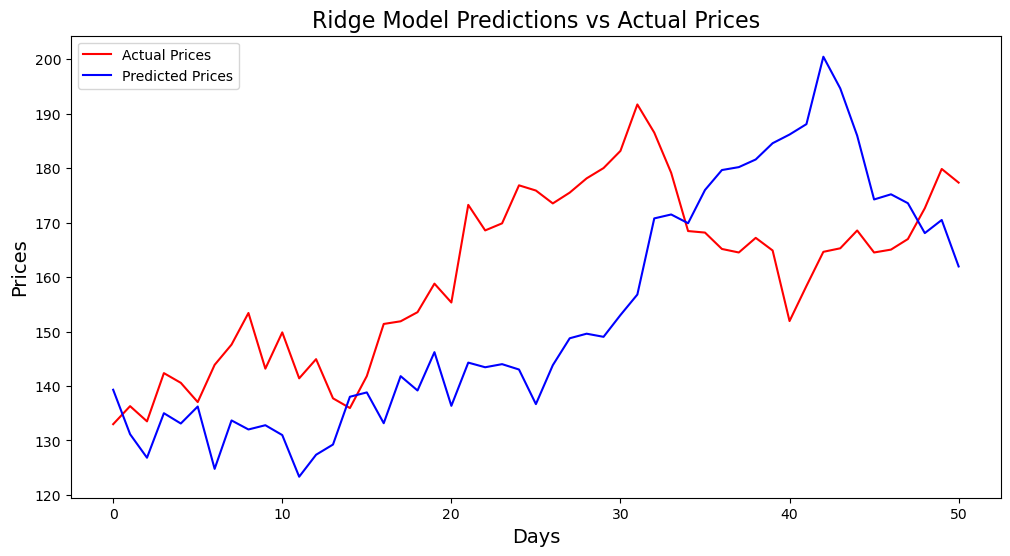

In [58]:
# Make predictions
predictions = ridge.predict(X_test)

# Inverse transform to get the original scale for predicted prices
predictions_scaled = scaler.inverse_transform(predictions.reshape(1,-1)).reshape(-1,1)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='red')
plt.plot(predictions_scaled, label='Predicted Prices', color='blue')
plt.title('Ridge Model Predictions vs Actual Prices', fontsize=16)
plt.xscale
plt.xlabel('Days', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.legend()
plt.show()

####  Plotly interactive visualization
- Helps to zoom in and zoom out
- We can see the best prediction is biased towards the previous week price


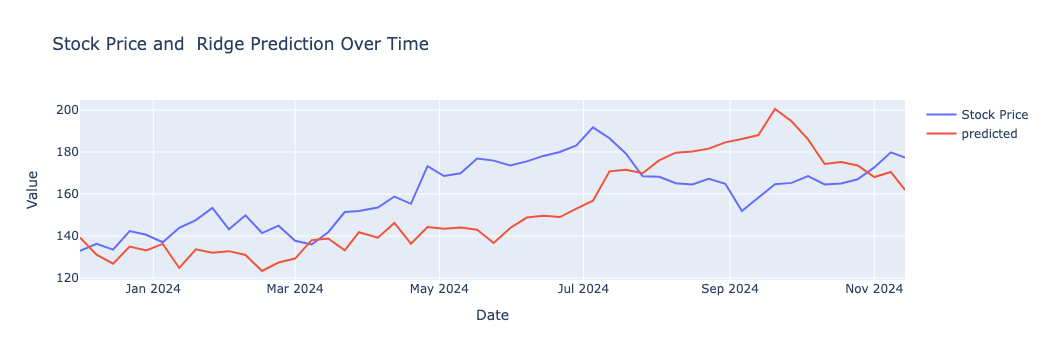

In [61]:
import plotly.express as px
import plotly.graph_objects as go
datetime_array =dates[-len(y_test_scaled):]

# Convert to date string array
date_string_array = np.datetime_as_string(datetime_array, unit='D')
trace1 = go.Scatter(x=date_string_array, y=y_test_scaled.reshape(1,-1)[0], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=date_string_array, y=predictions_scaled.reshape(1,-1)[0], mode='lines', name='predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and  Ridge Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()


#### LSTM 

#### 3.1 Build the model

In [65]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



#### 3.2 Change the shape for data set

In [68]:
X_train_in = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_in =X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

##### 3.3 Train and Test the model

In [71]:
# Fit the model
model.fit(X_train_in, y_train, batch_size=32, epochs=100,verbose=False)

# Make predictions
predictions = model.predict(X_test_in)
y_val_lstm= model.predict(X_val.reshape(X_val.shape[0], X_val.shape[1], 1))


# Inverse transform to get the original scale for predicted prices
predictions_scaled = scaler.inverse_transform(predictions)
y_val_lstm=scaler.inverse_transform(y_val_lstm)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# model.eval()
# Evaluate the model performance
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Squared Error: 0.03001397427009761


In [72]:
import plotly.express as px
import plotly.graph_objects as go
datetime_array =dates[-len(y_test_scaled):]

# Convert to date string array
date_string_array = np.datetime_as_string(datetime_array, unit='D')
trace1 = go.Scatter(x=date_string_array, y=y_test_scaled.reshape(1,-1)[0], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=date_string_array, y=predictions_scaled.reshape(1,-1)[0], mode='lines', name='LSTM')

# Create the layout
layout = go.Layout(
    title='Stock Price and  Ridge Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()


**NEW LSTM MODEL**

/var/folders/p0/zp106ryj0yj0_399lc8y42v40000gn/T/ipykernel_24246/642146102.py:105: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Sentiment Value'].fillna(combined_df['Sentiment Value'].median(), inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Performance Metrics DataFrame:
   Batch Size      RMSE       MAE      MAPE   DA
0          16  5.286349  4.712881  2.939815  1.0
1          32  5.472187  5.019222  3.160295  1.0
2          64  5.976931  5.396686  3.391122  1.0
3         128  5.931644  5.303745  3.347427  1.0


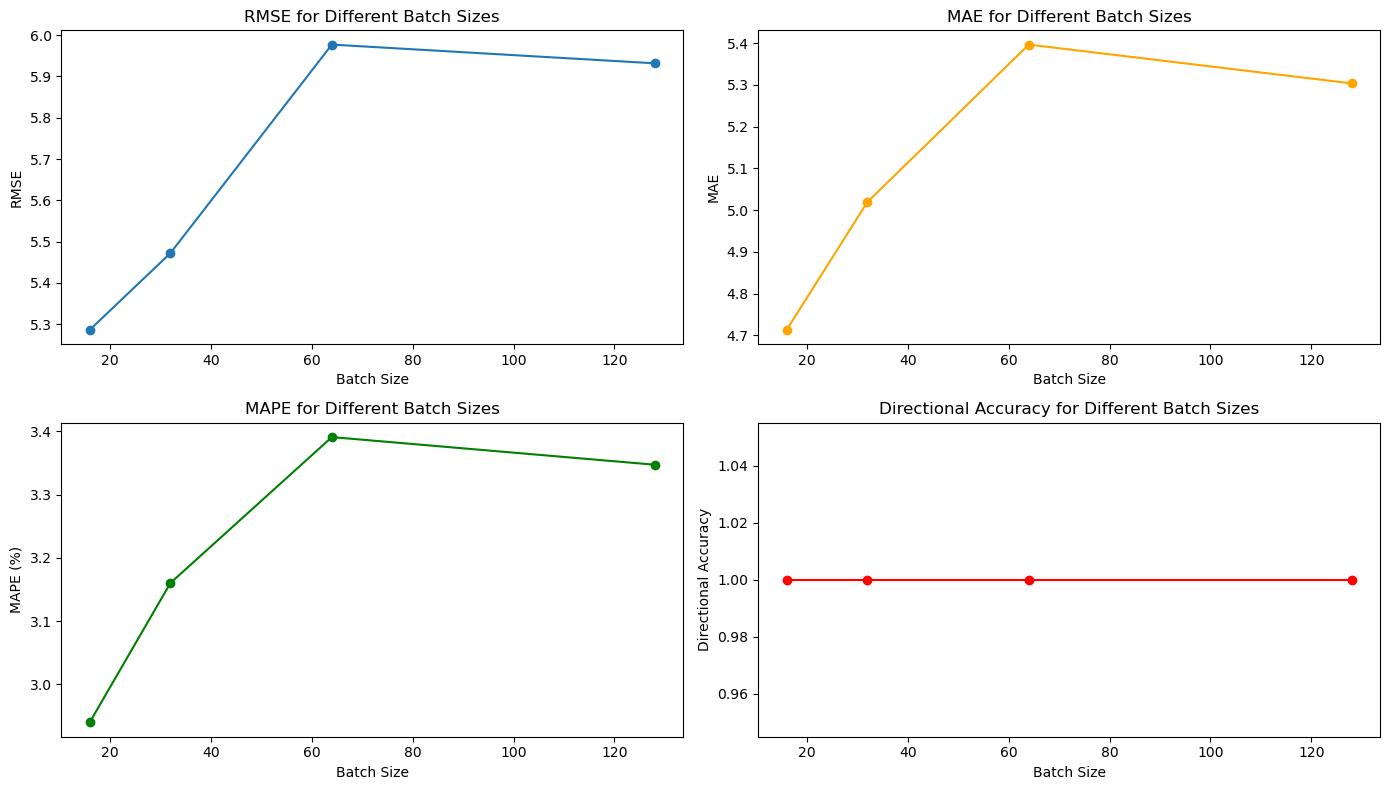

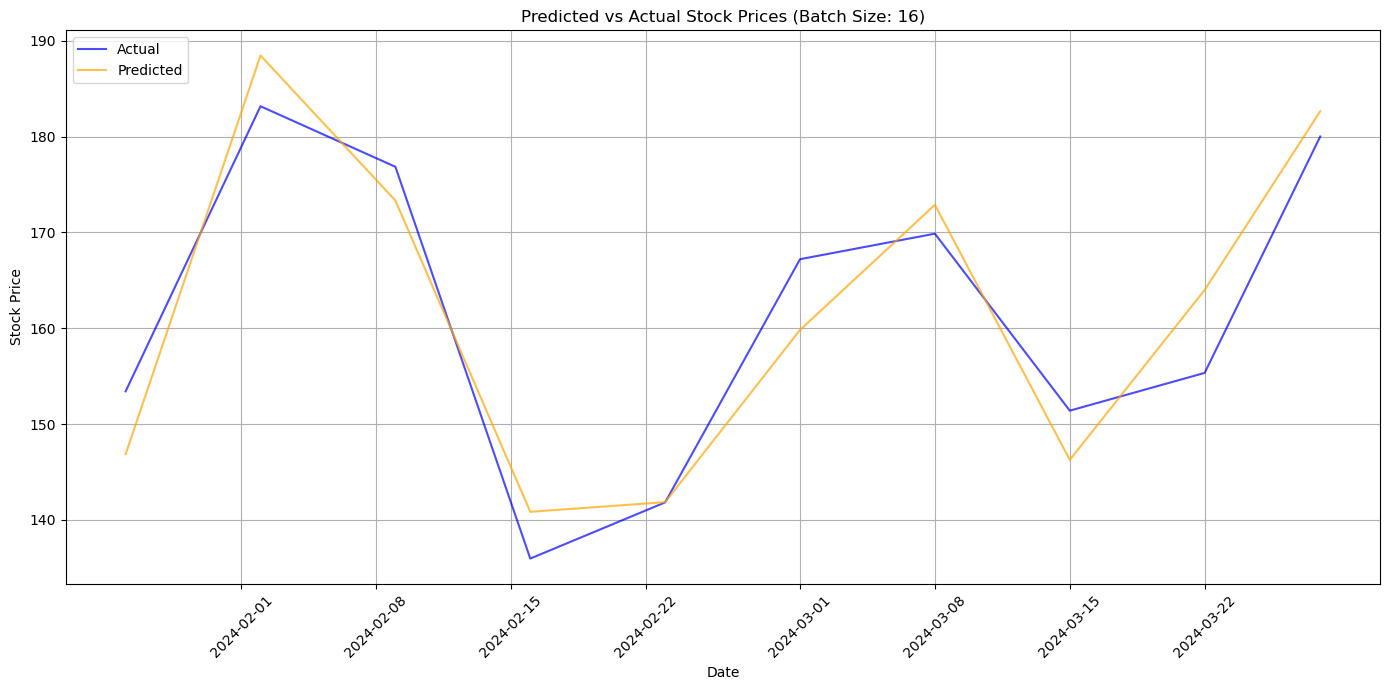

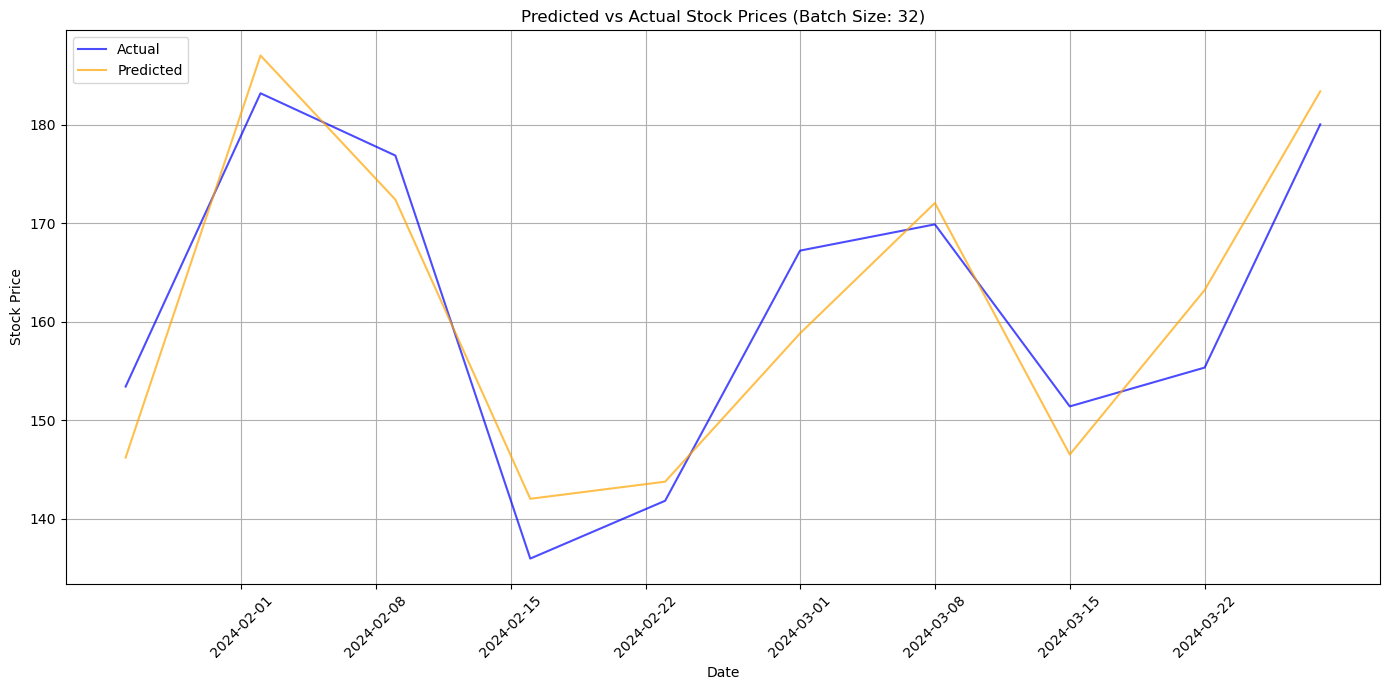

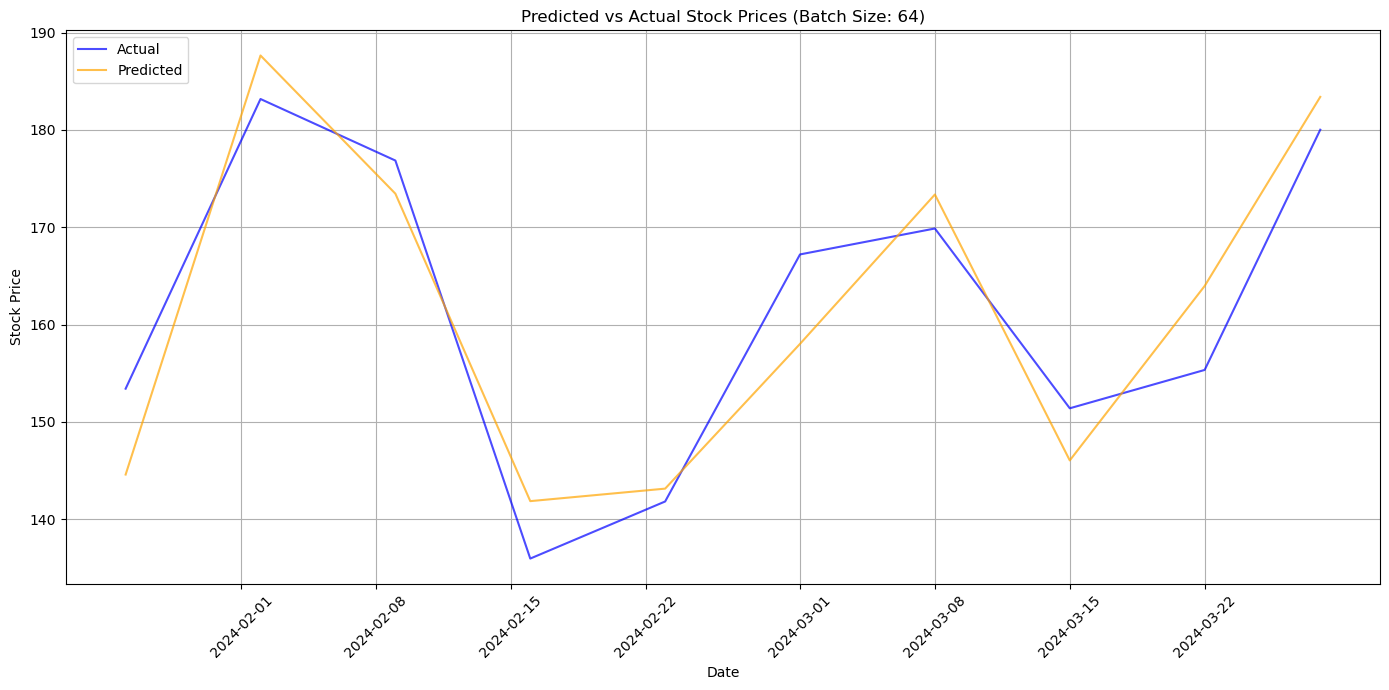

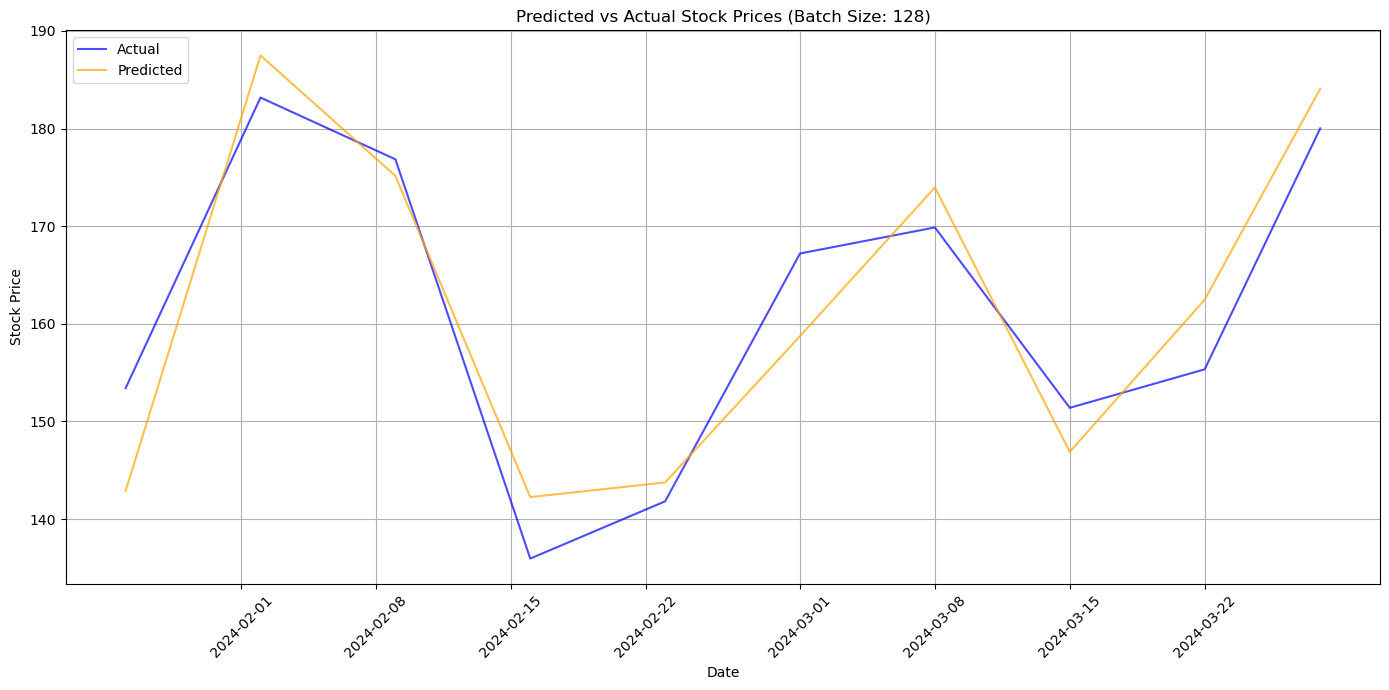

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

# Normalizer class definition
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        x = np.array(x)
        self.mu = np.mean(x, axis=0, keepdims=True)
        self.sd = np.std(x, axis=0, keepdims=True)
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu

# Load data
stock = "GOOG"
df_stock = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_weekly_adjusted.csv',
                       header=0, index_col=0, parse_dates=[0], thousands=',')
df_earnings = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_earnings.csv',
                          header=0, parse_dates=['fiscalDateEnding', 'reportedDate'])
df_insider = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_insider_transactions.csv',
                          header=0, parse_dates=['Transaction Date'])
df_news = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_news_sentiment.csv',
                      header=0, parse_dates=['Time Published'])


# Sentiment Label Mapping to Numeric Values
sentiment_mapping = {
    'Bullish': 1,
    'Somewhat-Bullish': 2,
    'Neutral': 3,
    'Somewhat-Bearish': 4,
    'Bearish': 5
}

# Map the sentiment labels to numerical values
df_news['Sentiment Value'] = df_news['Sentiment Label'].map(sentiment_mapping)

# Combine news sentiment for each week
df_news['Week'] = df_news['Time Published'].dt.to_period('W').apply(lambda r: r.start_time)

# Calculate weekly average sentiment score
weekly_sentiment = df_news.groupby('Week')['Sentiment Value'].mean().reset_index()

# Load the stock data
closing_prices = df_stock['Adjusted Close'].values
volume = df_stock['Volume'].values  # Extract Volume
surprise_percentage = df_earnings['surprisePercentage'].values
insider_transactions = df_insider['Shares'].values  

min_length = min(len(closing_prices), len(surprise_percentage), len(insider_transactions))

# Prepare surprise percentages
price_dates = df_stock.index[:min_length]
surprise_array = np.zeros(len(price_dates))

for _, row in df_earnings.iterrows():
    quarter_end = row['fiscalDateEnding']
    quarter_start = quarter_end - pd.DateOffset(months=3)
    within_quarter_mask = (price_dates >= quarter_start) & (price_dates <= quarter_end)
    num_weeks = np.sum(within_quarter_mask)
    
    if num_weeks > 0:
        surprise_array[within_quarter_mask] = row['surprisePercentage'] / num_weeks

# Combine data into a DataFrame
combined_df = pd.DataFrame({
    'Date': df_stock.index[:min_length],
    'Closing Prices': closing_prices[:min_length],
    'Surprise Percentage': surprise_array[:min_length],
    'Insider Transactions': insider_transactions[:min_length],
    'Volume': volume[:min_length]  # Add Volume to the DataFrame
})

# Calculate Insider Transactions Impact
combined_df['Week'] = combined_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
df_insider['Week'] = df_insider['Transaction Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Group insider transactions by week and type (Acquisition or Disposal)
weekly_transactions = df_insider.groupby(['Week', 'Acquisition or Disposal'])['Shares'].sum().unstack(fill_value=0)
weekly_transactions.columns = ['Disposal', 'Acquisition']
weekly_transactions.reset_index(inplace=True)

# Merge insider transaction data
combined_df = combined_df.merge(weekly_transactions, on='Week', how='left')

# Calculate Market Impact
combined_df['Market Impact'] = combined_df['Acquisition'] - combined_df['Disposal']
combined_df.fillna(0, inplace=True)

# Merge weekly sentiment data into combined_df
combined_df = combined_df.merge(weekly_sentiment, left_on='Week', right_on='Week', how='left')

# Fill any missing sentiment data with the median sentiment of the dataset
combined_df['Sentiment Value'].fillna(combined_df['Sentiment Value'].median(), inplace=True)

# Prepare combined data for LSTM (features: Closing Price, Surprise Percentage, Insider Transactions, Volume, etc.)
combined_data = np.column_stack((
    closing_prices[:min_length],
    surprise_array[:min_length],
    insider_transactions[:min_length],
    combined_df['Disposal'].values,
    combined_df['Acquisition'].values,
    combined_df['Volume'].values,
    combined_df['Sentiment Value'].values  # Add News Sentiment as an additional feature
))

# Normalize combined data
normalizer = Normalizer()
combined_data_scaled = normalizer.fit_transform(combined_data)

# Function to create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Predict closing price
    return np.array(X), np.array(y)

# Set time step for LSTM
time_step = 10
X, y = create_dataset(combined_data_scaled, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Loop through different batch sizes for error metrics and plotting
batch_sizes = [16, 32, 64, 128]
metrics = []
all_predictions = []  # predictions for each batch size

for batch_size in batch_sizes:
    # Define the LSTM model for each batch size
    model = tf.keras.Sequential([
       Input(shape=(X_train.shape[1], X_train.shape[2])),  # Define input shape here
       LSTM(50, return_sequences=True),
       Dropout(0.25),
       LSTM(50, return_sequences=False),
       Dropout(0.25),
       Dense(25),
       Dense(1)  # Output layer for predicting stock prices
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=100, verbose=0)  # Set verbose to 0 for less output

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Inverse transform the predictions
    predictions_inv = normalizer.inverse_transform(np.column_stack((predictions, 
                                                                  np.zeros(predictions.shape), 
                                                                  np.zeros(predictions.shape), 
                                                                  np.zeros(predictions.shape), 
                                                                  np.zeros(predictions.shape), 
                                                                  np.zeros(predictions.shape), 
                                                                  np.zeros(predictions.shape))))[:, 0]

    # Inverse transform the test values
    y_test_scaled = normalizer.inverse_transform(np.column_stack((y_test.reshape(-1, 1), 
                                                                   np.zeros(y_test.shape), 
                                                                   np.zeros(y_test.shape), 
                                                                   np.zeros(y_test.shape), 
                                                                   np.zeros(y_test.shape), 
                                                                   np.zeros(y_test.shape), 
                                                                   np.zeros(y_test.shape))))[:, 0]

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions_inv))
    mae = mean_absolute_error(y_test_scaled, predictions_inv)
    mape = np.mean(np.abs((y_test_scaled - predictions_inv) / y_test_scaled)) * 100
    da = np.mean(np.sign(y_test_scaled[1:] - y_test_scaled[:-1]) == np.sign(predictions_inv[1:] - predictions_inv[:-1]))

    metrics.append({
        'Batch Size': batch_size,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'DA': da
    })

    all_predictions.append({
        'Batch Size': batch_size,
        'Actual': y_test_scaled,
        'Predicted': predictions_inv
    })

# Convert metrics into DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

# Print the performance metrics DataFrame
print("Performance Metrics DataFrame:")
print(metrics_df)

# Optional: Visualize the performance metrics for each batch size
plt.figure(figsize=(14, 8))

# RMSE Plot
plt.subplot(2, 2, 1)
plt.plot(metrics_df['Batch Size'], metrics_df['RMSE'], marker='o')
plt.title('RMSE for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')

# MAE Plot
plt.subplot(2, 2, 2)
plt.plot(metrics_df['Batch Size'], metrics_df['MAE'], marker='o', color='orange')
plt.title('MAE for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('MAE')

# MAPE Plot
plt.subplot(2, 2, 3)
plt.plot(metrics_df['Batch Size'], metrics_df['MAPE'], marker='o', color='green')
plt.title('MAPE for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('MAPE (%)')

# Directional Accuracy Plot
plt.subplot(2, 2, 4)
plt.plot(metrics_df['Batch Size'], metrics_df['DA'], marker='o', color='red')
plt.title('Directional Accuracy for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('Directional Accuracy')


plt.tight_layout()
plt.show()

for batch_size in batch_sizes:
    # predictions and actual values for the batch size
    prediction_data = next(item for item in all_predictions if item['Batch Size'] == batch_size)
    
    predicted_values = prediction_data['Predicted']
    actual_values = prediction_data['Actual']
    
    # Get corresponding dates for the actual values
    dates = combined_df['Date'].values[-len(actual_values):]  # Ensure correct length
    
    # Plot predicted vs actual values
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual_values, label='Actual', color='blue', alpha=0.7)
    plt.plot(dates, predicted_values, label='Predicted', color='orange', alpha=0.7)
    
    plt.title(f'Predicted vs Actual Stock Prices (Batch Size: {batch_size})')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()  # To avoid label clipping
    plt.show()

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 3.0877 - val_loss: 3.1810 - learning_rate: 1.0000e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0652 - val_loss: 3.1634 - learning_rate: 1.0000e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0737 - val_loss: 3.1461 - learning_rate: 1.0000e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1183 - val_loss: 3.1289 - learning_rate: 1.0000e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0660 - val_loss: 3.1121 - learning_rate: 1.0000e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0685 - val_loss: 3.0954 - learning_rate: 1.0000e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0145 - val_loss: 3.0788 - learning_rate: 1.0000e-04
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0196 - val_loss: 3.0624 - learning_rate: 1.0000e-04
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9913 - val_loss: 3.0461 - learning_rate: 1.0000e-04
Epo

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.0915 - val_loss: 3.1761 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.0756 - val_loss: 3.1665 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0767 - val_loss: 3.1572 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0609 - val_loss: 3.1481 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.0669 - val_loss: 3.1389 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0548 - val_loss: 3.1300 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.0451 - val_loss: 3.1211 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0241 - val_loss: 3.1122 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0355 - val_loss: 3.1033 - learning_rate: 1.0000e-04
Epoch 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.1274 - val_loss: 3.2074 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.1296 - val_loss: 3.1983 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.1029 - val_loss: 3.1892 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.1017 - val_loss: 3.1803 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.1058 - val_loss: 3.1713 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0968 - val_loss: 3.1624 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0687 - val_loss: 3.1535 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0744 - val_loss: 3.1448 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.0710 - val_loss: 3.1361 - learning_rate: 1.0000e-04
Epoch 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.1248 - val_loss: 3.1874 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.1031 - val_loss: 3.1791 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.1027 - val_loss: 3.1712 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.0933 - val_loss: 3.1634 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0813 - val_loss: 3.1555 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0664 - val_loss: 3.1478 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.0857 - val_loss: 3.1402 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.0644 - val_loss: 3.1327 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.0431 - val_loss: 3.1251 - learning_rate: 1.0000e-04
Epoch 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 3.0935 - val_loss: 2.9847 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9119 - val_loss: 2.8304 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7580 - val_loss: 2.6901 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5586 - val_loss: 2.5494 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5115 - val_loss: 2.4171 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.3432 - val_loss: 2.2946 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2551 - val_loss: 2.1798 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1594 - val_loss: 2.0802 - learning_rate: 0.0010
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0453 - val_loss: 1.9921 - learning_rate: 0.0010
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.1056 - val_loss: 3.0864 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.0139 - val_loss: 2.9980 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.9314 - val_loss: 2.9128 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8481 - val_loss: 2.8334 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.7965 - val_loss: 2.7583 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6827 - val_loss: 2.6865 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6344 - val_loss: 2.6166 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.5649 - val_loss: 2.5489 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4848 - val_loss: 2.4818 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.1019 - val_loss: 3.0754 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.0130 - val_loss: 2.9969 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.9352 - val_loss: 2.9156 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8379 - val_loss: 2.8308 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.7544 - val_loss: 2.7436 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.6851 - val_loss: 2.6566 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6033 - val_loss: 2.5728 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5505 - val_loss: 2.4925 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4983 - val_loss: 2.4166 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.1145 - val_loss: 3.1020 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.0275 - val_loss: 3.0169 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.9560 - val_loss: 2.9408 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8862 - val_loss: 2.8619 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.8033 - val_loss: 2.7832 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.7417 - val_loss: 2.7046 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.6600 - val_loss: 2.6256 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.5863 - val_loss: 2.5465 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.4901 - val_loss: 2.4678 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 3.0763 - val_loss: 2.1937 - learning_rate: 0.0100
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1015 - val_loss: 1.4464 - learning_rate: 0.0100
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4102 - val_loss: 0.9419 - learning_rate: 0.0100
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9064 - val_loss: 0.7041 - learning_rate: 0.0100
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6534 - val_loss: 0.5966 - learning_rate: 0.0100
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5827 - val_loss: 0.5371 - learning_rate: 0.0100
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4892 - val_loss: 0.4573 - learning_rate: 0.0100
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4333 - val_loss: 0.4295 - learning_rate: 0.0100
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4571 - val_loss: 0.4114 - learning_rate: 0.0100
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.1199 - val_loss: 2.6075 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.5415 - val_loss: 2.0384 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.0091 - val_loss: 1.5722 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6094 - val_loss: 1.2279 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2282 - val_loss: 0.9952 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0903 - val_loss: 0.9332 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8899 - val_loss: 0.7490 - learning_rate: 0.0100
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7752 - val_loss: 0.6341 - learning_rate: 0.0100
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6582 - val_loss: 0.5759 - learning_rate: 0.0100
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.0964 - val_loss: 2.3495 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.3729 - val_loss: 2.0323 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0647 - val_loss: 1.5373 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6168 - val_loss: 1.3010 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3472 - val_loss: 1.1099 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1405 - val_loss: 0.9297 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9264 - val_loss: 0.7813 - learning_rate: 0.0100
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7749 - val_loss: 0.6648 - learning_rate: 0.0100
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6736 - val_loss: 0.5767 - learning_rate: 0.0100
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.1302 - val_loss: 2.5581 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.4391 - val_loss: 2.0089 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9628 - val_loss: 1.5158 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6176 - val_loss: 1.2172 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2841 - val_loss: 1.0092 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0545 - val_loss: 0.8430 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8842 - val_loss: 0.8017 - learning_rate: 0.0100
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8139 - val_loss: 0.6095 - learning_rate: 0.0100
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6279 - val_loss: 0.5846 - learning_rate: 0.0100
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 5.1164 - val_loss: 5.1669 - learning_rate: 1.0000e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0799 - val_loss: 5.1399 - learning_rate: 1.0000e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0453 - val_loss: 5.1136 - learning_rate: 1.0000e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.9999 - val_loss: 5.0873 - learning_rate: 1.0000e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9963 - val_loss: 5.0608 - learning_rate: 1.0000e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.9883 - val_loss: 5.0342 - learning_rate: 1.0000e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.9923 - val_loss: 5.0079 - learning_rate: 1.0000e-04
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.9080 - val_loss: 4.9818 - learning_rate: 1.0000e-04
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9498 - val_loss: 4.9553 - learning_rate: 1.0000e-04
Epo

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.0828 - val_loss: 5.1425 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0690 - val_loss: 5.1270 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0585 - val_loss: 5.1115 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.0273 - val_loss: 5.0961 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0253 - val_loss: 5.0810 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0067 - val_loss: 5.0659 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0022 - val_loss: 5.0511 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9817 - val_loss: 5.0365 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9664 - val_loss: 5.0220 - learning_rate: 1.0000e-04
Epoch 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.1036 - val_loss: 5.1820 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.1034 - val_loss: 5.1675 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0869 - val_loss: 5.1531 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0824 - val_loss: 5.1386 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.0605 - val_loss: 5.1240 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0568 - val_loss: 5.1095 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0329 - val_loss: 5.0950 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0132 - val_loss: 5.0807 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0084 - val_loss: 5.0665 - learning_rate: 1.0000e-04
Epoch 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.0778 - val_loss: 5.1393 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0589 - val_loss: 5.1246 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.0395 - val_loss: 5.1099 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.0409 - val_loss: 5.0954 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.0249 - val_loss: 5.0809 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9962 - val_loss: 5.0664 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.9812 - val_loss: 5.0517 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9613 - val_loss: 5.0368 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9550 - val_loss: 5.0220 - learning_rate: 1.0000e-04
Epoch 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 5.0969 - val_loss: 4.9484 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8841 - val_loss: 4.7119 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.6178 - val_loss: 4.4792 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4181 - val_loss: 4.2504 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.1656 - val_loss: 4.0184 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.9311 - val_loss: 3.7825 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.6900 - val_loss: 3.5510 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.5337 - val_loss: 3.3417 - learning_rate: 0.0010
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.3106 - val_loss: 3.1621 - learning_rate: 0.0010
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.1077 - val_loss: 5.0529 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9721 - val_loss: 4.9229 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.8508 - val_loss: 4.7950 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7199 - val_loss: 4.6661 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.6175 - val_loss: 4.5354 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.4686 - val_loss: 4.4042 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3596 - val_loss: 4.2730 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.2396 - val_loss: 4.1445 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.0869 - val_loss: 4.0153 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.1291 - val_loss: 5.0726 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.9828 - val_loss: 4.9450 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8543 - val_loss: 4.8158 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7254 - val_loss: 4.6833 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.6010 - val_loss: 4.5511 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.4624 - val_loss: 4.4180 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.3511 - val_loss: 4.2855 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.2040 - val_loss: 4.1544 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.0833 - val_loss: 4.0268 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.0900 - val_loss: 5.0035 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9257 - val_loss: 4.8560 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7993 - val_loss: 4.7111 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.6694 - val_loss: 4.5683 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.5178 - val_loss: 4.4259 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.4107 - val_loss: 4.2855 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.2329 - val_loss: 4.1458 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.1296 - val_loss: 4.0109 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.9912 - val_loss: 3.8849 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 4.9131 - val_loss: 3.4099 - learning_rate: 0.0100
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.2882 - val_loss: 2.1376 - learning_rate: 0.0100
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0209 - val_loss: 1.3503 - learning_rate: 0.0100
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4361 - val_loss: 1.0275 - learning_rate: 0.0100
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0926 - val_loss: 0.9729 - learning_rate: 0.0100
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9181 - val_loss: 0.8360 - learning_rate: 0.0100
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7960 - val_loss: 0.7635 - learning_rate: 0.0100
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7793 - val_loss: 0.8161 - learning_rate: 0.0100
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7932 - val_loss: 0.6915 - learning_rate: 0.0100
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.1021 - val_loss: 4.1043 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0144 - val_loss: 3.0170 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.1134 - val_loss: 2.3390 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.3969 - val_loss: 1.9520 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0105 - val_loss: 1.5901 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.6247 - val_loss: 1.1865 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2074 - val_loss: 0.9964 - learning_rate: 0.0100
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0776 - val_loss: 0.8415 - learning_rate: 0.0100
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8224 - val_loss: 0.7461 - learning_rate: 0.0100
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.0783 - val_loss: 4.1079 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.9830 - val_loss: 2.9850 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.0490 - val_loss: 2.5239 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.6789 - val_loss: 2.0482 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.1793 - val_loss: 1.6198 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6145 - val_loss: 1.3136 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3367 - val_loss: 1.1228 - learning_rate: 0.0100
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1700 - val_loss: 0.9713 - learning_rate: 0.0100
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0274 - val_loss: 0.8453 - learning_rate: 0.0100
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.0885 - val_loss: 4.0948 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.9986 - val_loss: 2.9770 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.0068 - val_loss: 2.4102 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.4130 - val_loss: 1.8367 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0192 - val_loss: 1.4931 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5153 - val_loss: 1.2362 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2645 - val_loss: 0.9965 - learning_rate: 0.0100
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0418 - val_loss: 0.8205 - learning_rate: 0.0100
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8770 - val_loss: 0.7393 - learning_rate: 0.0100
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 6.7316 - val_loss: 6.7570 - learning_rate: 1.0000e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.6337 - val_loss: 6.7228 - learning_rate: 1.0000e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.6445 - val_loss: 6.6891 - learning_rate: 1.0000e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.5701 - val_loss: 6.6555 - learning_rate: 1.0000e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.5913 - val_loss: 6.6218 - learning_rate: 1.0000e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.5619 - val_loss: 6.5883 - learning_rate: 1.0000e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.5057 - val_loss: 6.5550 - learning_rate: 1.0000e-04
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.5097 - val_loss: 6.5218 - learning_rate: 1.0000e-04
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.4350 - val_loss: 6.4888 - learning_rate: 1.0000e-04
Epo

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.6880 - val_loss: 6.7477 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.6682 - val_loss: 6.7296 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.6502 - val_loss: 6.7113 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.6374 - val_loss: 6.6932 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.6071 - val_loss: 6.6749 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.5942 - val_loss: 6.6566 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5746 - val_loss: 6.6385 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5607 - val_loss: 6.6203 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5456 - val_loss: 6.6022 - learning_rate: 1.0000e-04
Epoch 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.6825 - val_loss: 6.7502 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.6710 - val_loss: 6.7330 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.6532 - val_loss: 6.7158 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.6390 - val_loss: 6.6987 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.6233 - val_loss: 6.6814 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.6039 - val_loss: 6.6642 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5856 - val_loss: 6.6470 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5679 - val_loss: 6.6299 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5561 - val_loss: 6.6128 - learning_rate: 1.0000e-04
Epoch 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.6900 - val_loss: 6.7623 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.6817 - val_loss: 6.7450 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.6618 - val_loss: 6.7276 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.6472 - val_loss: 6.7102 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.6277 - val_loss: 6.6927 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.6091 - val_loss: 6.6752 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5963 - val_loss: 6.6577 - learning_rate: 1.0000e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5767 - val_loss: 6.6402 - learning_rate: 1.0000e-04
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5644 - val_loss: 6.6228 - learning_rate: 1.0000e-04
Epoch 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 6.6742 - val_loss: 6.4629 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.3876 - val_loss: 6.1403 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.0469 - val_loss: 5.8214 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.7498 - val_loss: 5.4992 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.4298 - val_loss: 5.1696 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.0832 - val_loss: 4.8524 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.8209 - val_loss: 4.5824 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.5328 - val_loss: 4.3500 - learning_rate: 0.0010
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3900 - val_loss: 4.1102 - learning_rate: 0.0010
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.7211 - val_loss: 6.6195 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5486 - val_loss: 6.4518 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.3788 - val_loss: 6.2831 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.2246 - val_loss: 6.1134 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.0376 - val_loss: 5.9409 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.8992 - val_loss: 5.7669 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.7152 - val_loss: 5.5892 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.5548 - val_loss: 5.4080 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.3783 - val_loss: 5.2232 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.7185 - val_loss: 6.6189 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5388 - val_loss: 6.4484 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.3801 - val_loss: 6.2778 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.2136 - val_loss: 6.1059 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.0453 - val_loss: 5.9310 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.8735 - val_loss: 5.7540 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.7112 - val_loss: 5.5756 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.5134 - val_loss: 5.3958 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.3675 - val_loss: 5.2189 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 6.7139 - val_loss: 6.6228 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.5529 - val_loss: 6.4538 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.3882 - val_loss: 6.2863 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.2173 - val_loss: 6.1185 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.0680 - val_loss: 5.9504 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.9051 - val_loss: 5.7806 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.7444 - val_loss: 5.6093 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.5548 - val_loss: 5.4354 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.4064 - val_loss: 5.2588 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 6.4006 - val_loss: 4.0490 - learning_rate: 0.0100
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.8428 - val_loss: 2.4905 - learning_rate: 0.0100
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3379 - val_loss: 1.4269 - learning_rate: 0.0100
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3972 - val_loss: 0.9200 - learning_rate: 0.0100
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9368 - val_loss: 0.7310 - learning_rate: 0.0100
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8095 - val_loss: 0.6996 - learning_rate: 0.0100
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7484 - val_loss: 0.7250 - learning_rate: 0.0100
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7481 - val_loss: 0.7115 - learning_rate: 0.0100
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6832 - val_loss: 0.6782 - learning_rate: 0.0100
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.7108 - val_loss: 5.2464 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.2184 - val_loss: 3.9967 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.0104 - val_loss: 3.0633 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.1038 - val_loss: 2.2327 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.2872 - val_loss: 1.7073 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8213 - val_loss: 1.3744 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4596 - val_loss: 1.0894 - learning_rate: 0.0100
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0871 - val_loss: 0.9662 - learning_rate: 0.0100
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.9611 - val_loss: 0.8237 - learning_rate: 0.0100
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.7309 - val_loss: 5.3286 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.2663 - val_loss: 3.9131 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.9337 - val_loss: 3.0119 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.1328 - val_loss: 2.3406 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.3339 - val_loss: 1.8593 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8089 - val_loss: 1.3928 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3780 - val_loss: 1.0798 - learning_rate: 0.0100
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0793 - val_loss: 0.9255 - learning_rate: 0.0100
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8866 - val_loss: 0.7522 - learning_rate: 0.0100
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 6.7345 - val_loss: 5.3127 - learning_rate: 0.0100
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.2449 - val_loss: 3.9148 - learning_rate: 0.0100
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.8865 - val_loss: 2.9231 - learning_rate: 0.0100
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.9603 - val_loss: 2.2312 - learning_rate: 0.0100
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.2682 - val_loss: 1.9751 - learning_rate: 0.0100
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9608 - val_loss: 1.4663 - learning_rate: 0.0100
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4202 - val_loss: 1.1628 - learning_rate: 0.0100
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1194 - val_loss: 0.9382 - learning_rate: 0.0100
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9168 - val_loss: 0.7949 - learning_rate: 0.0100
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

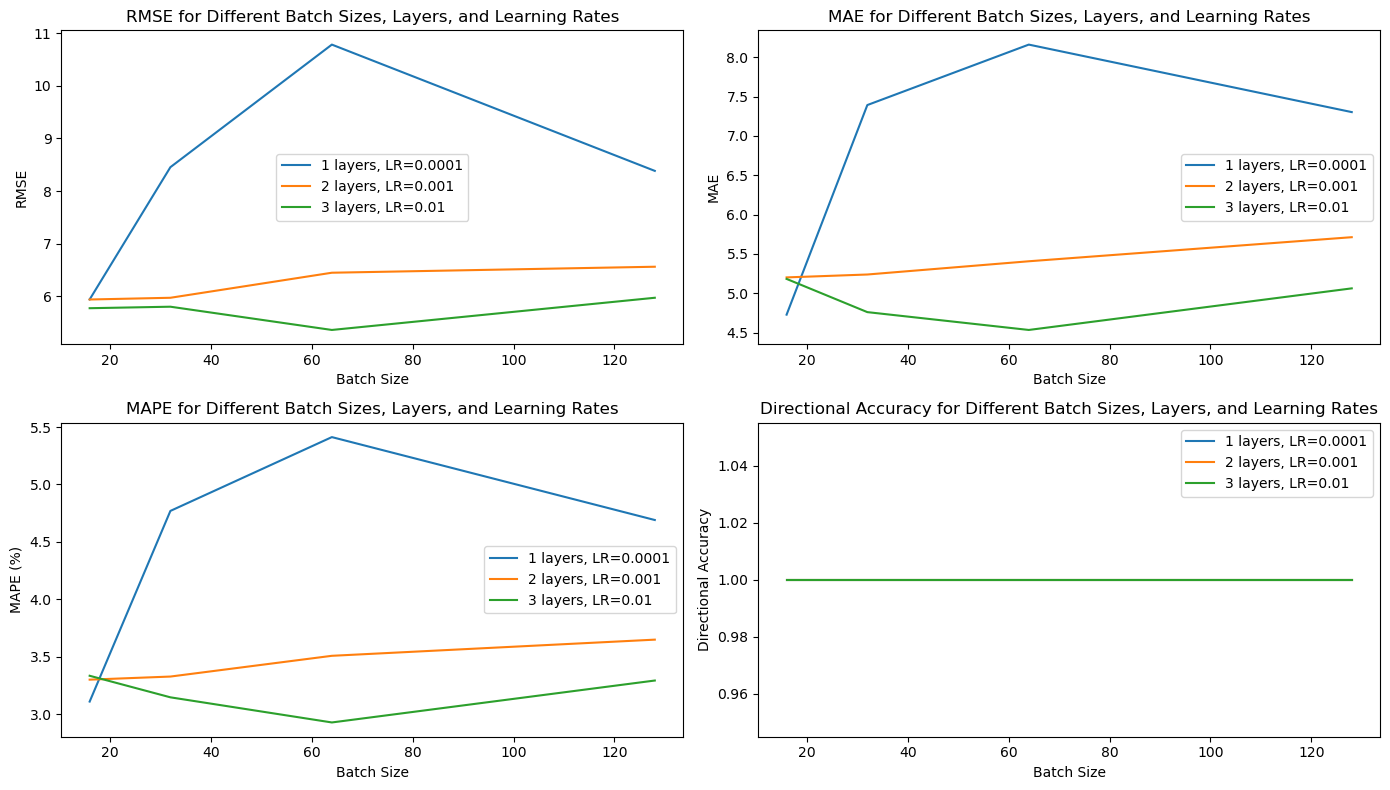

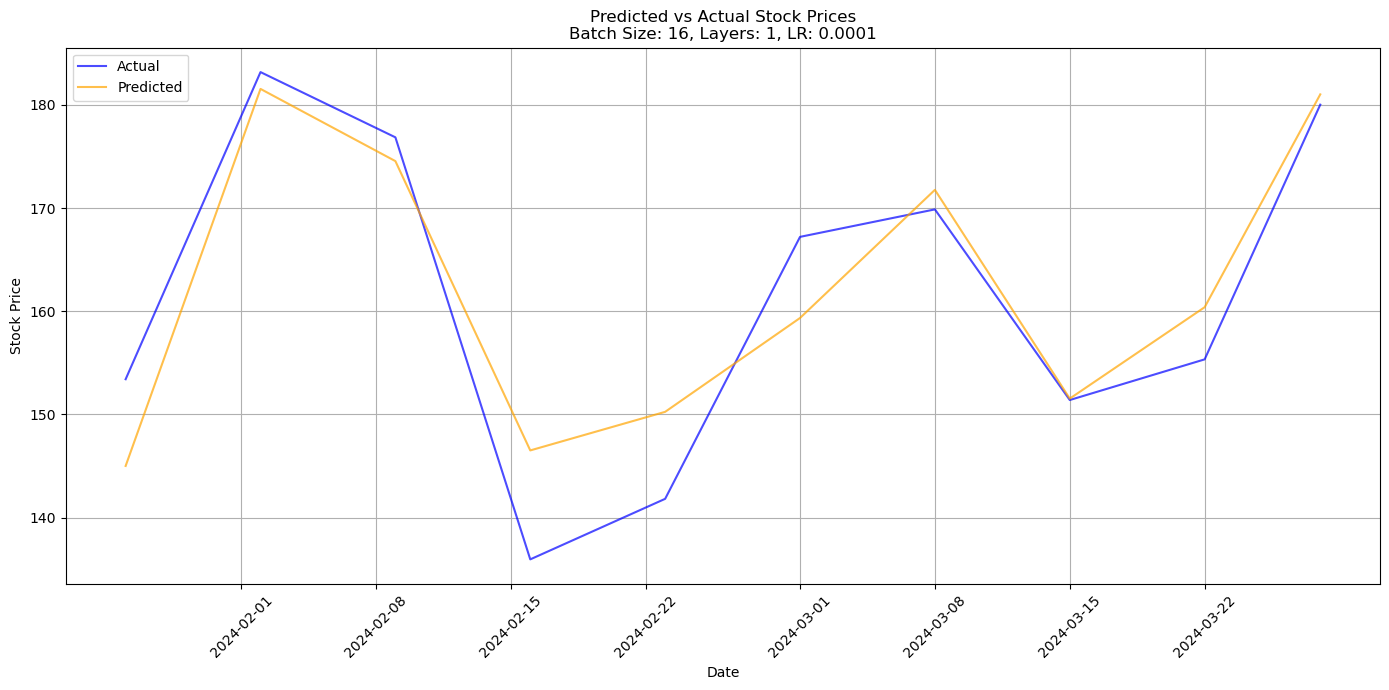

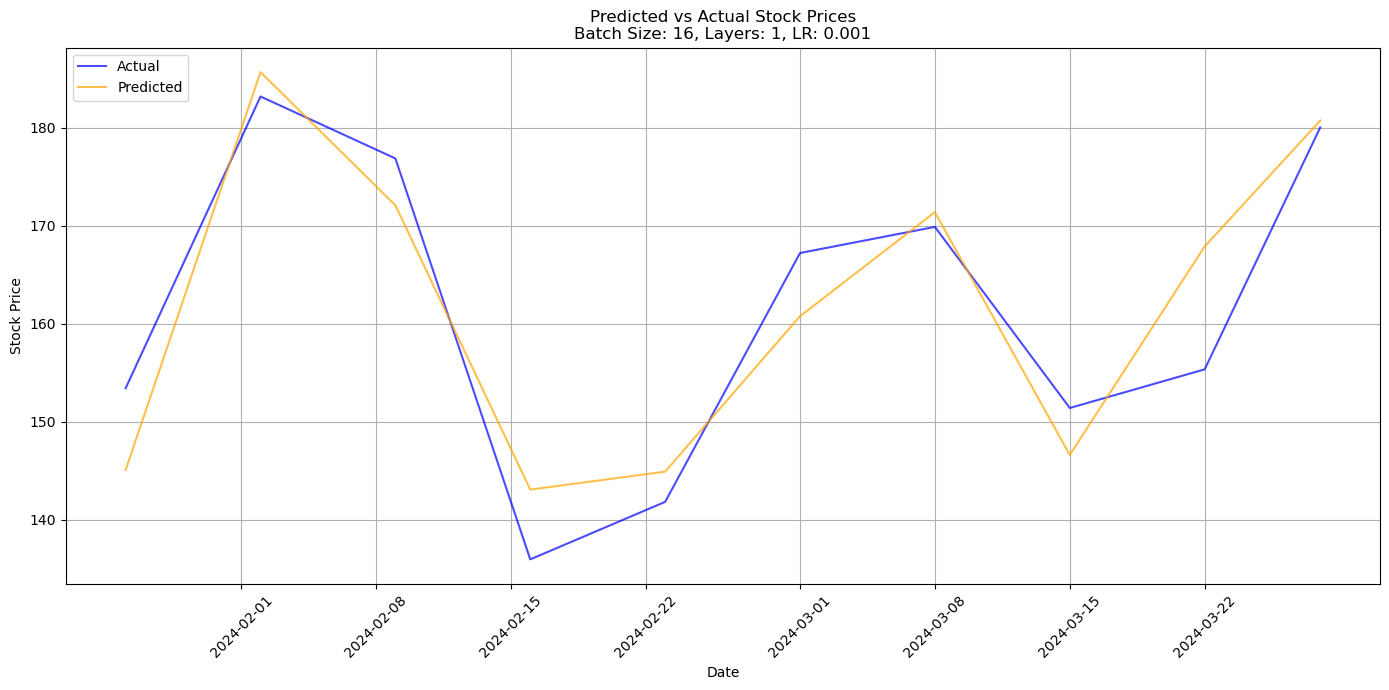

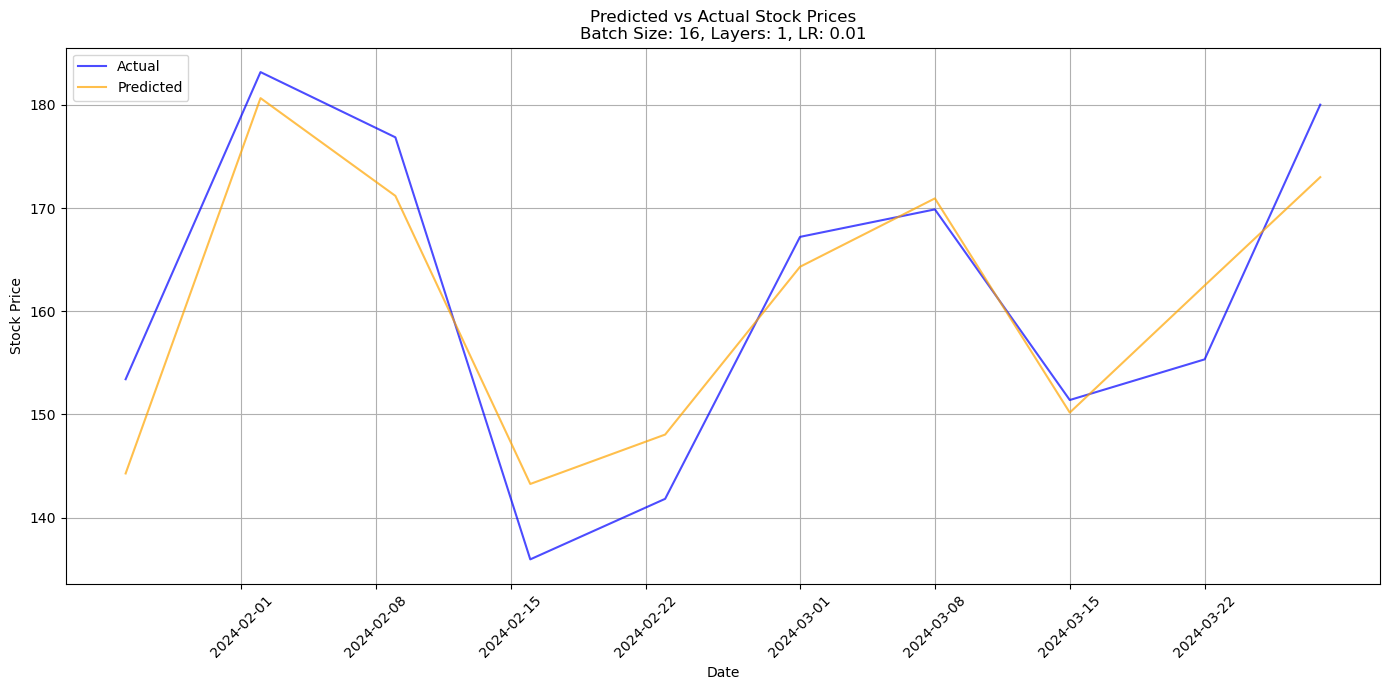

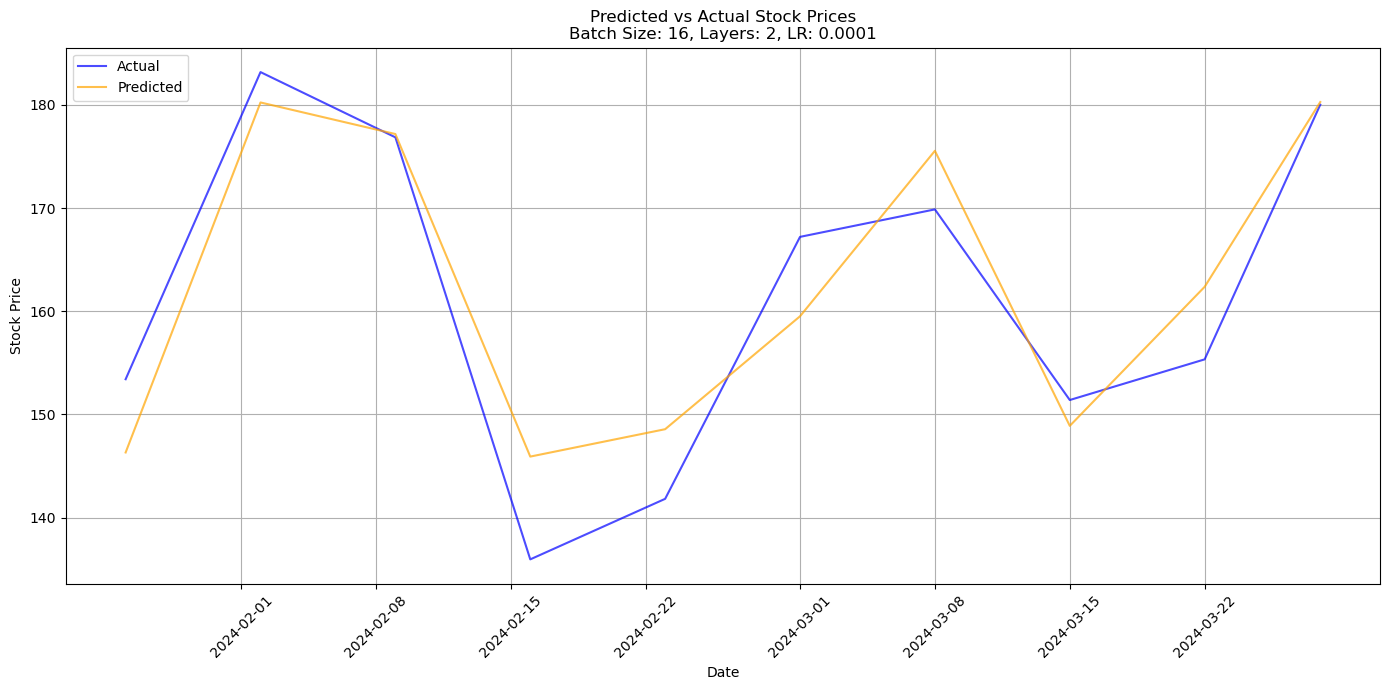

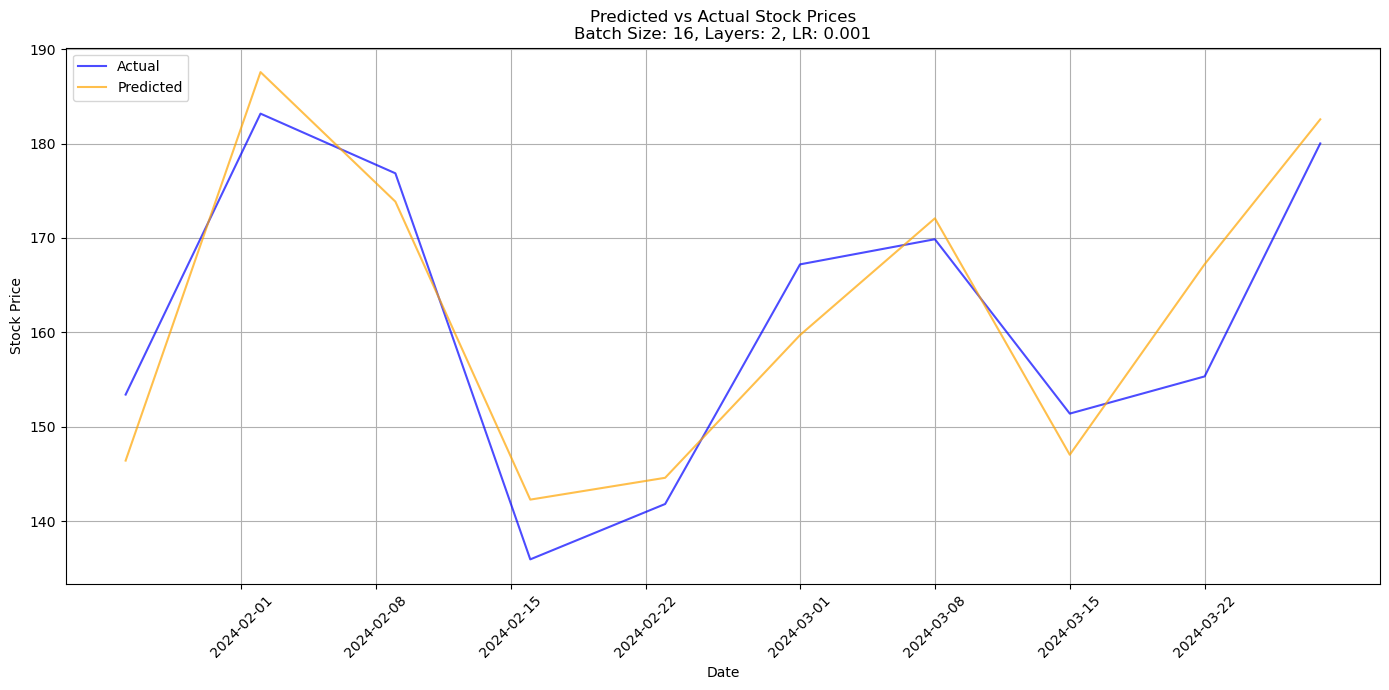

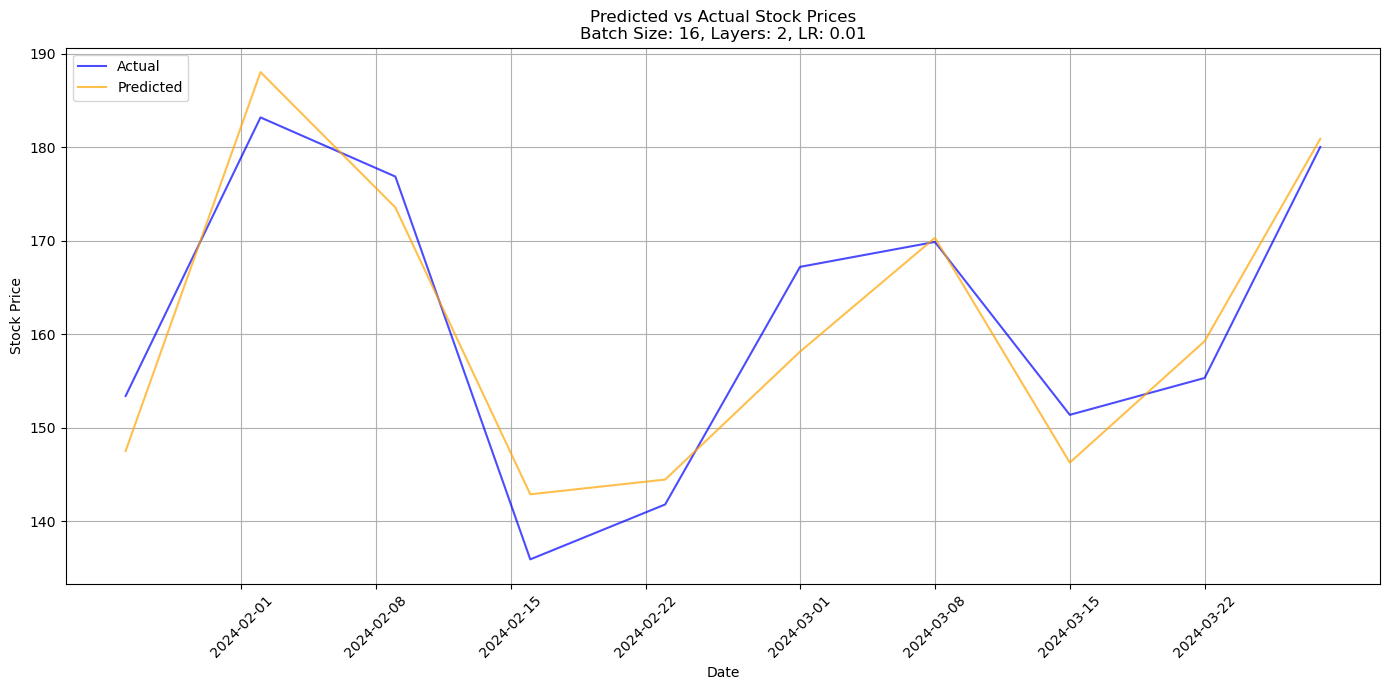

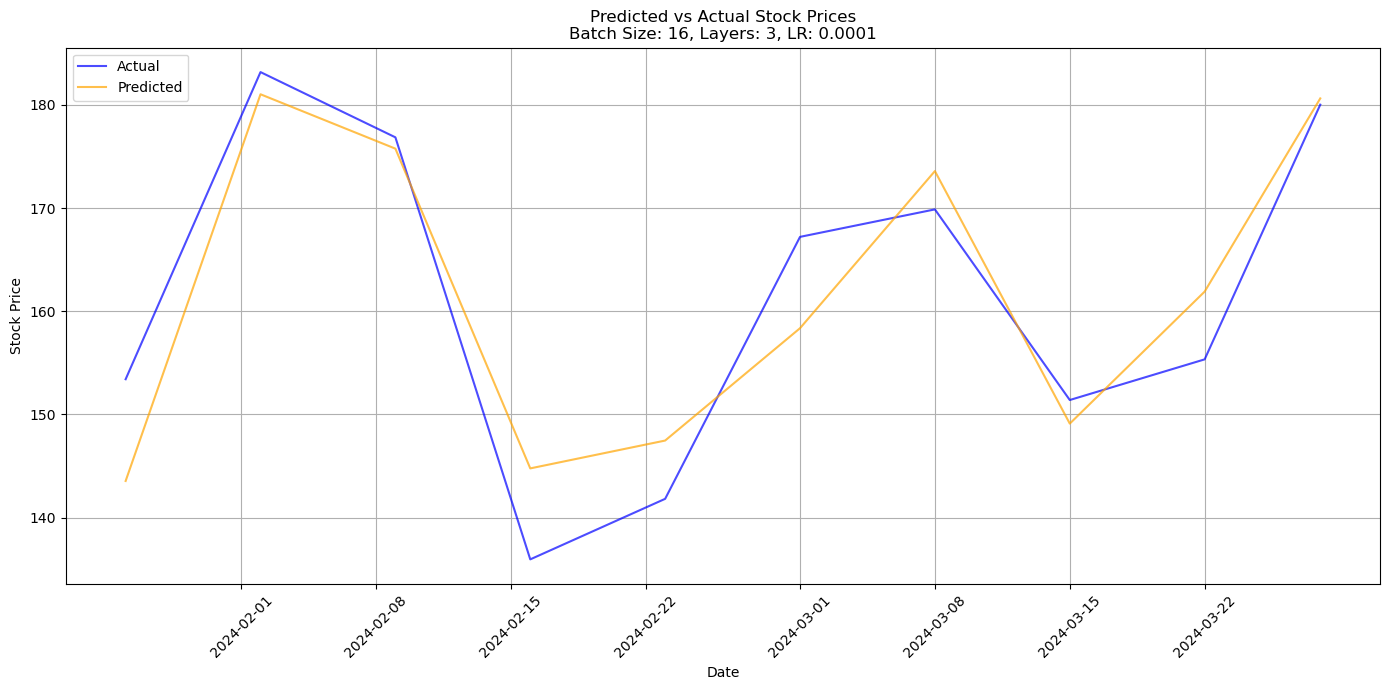

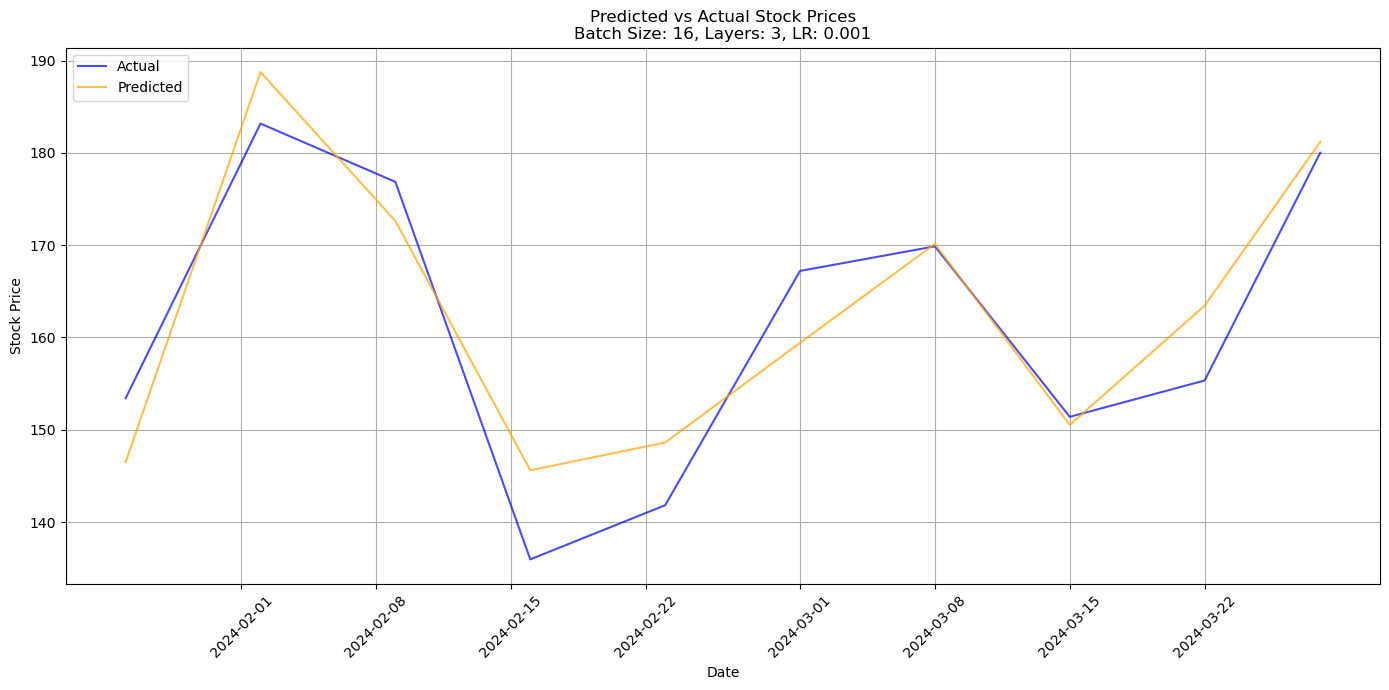

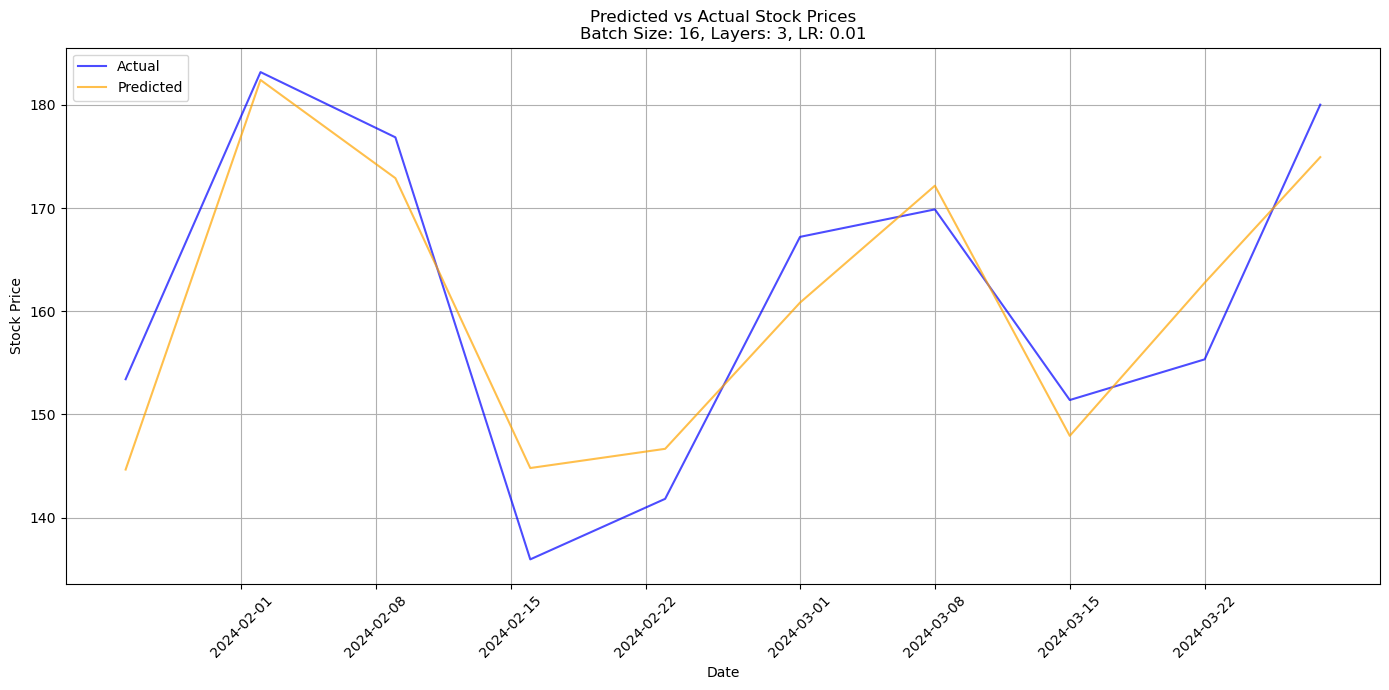

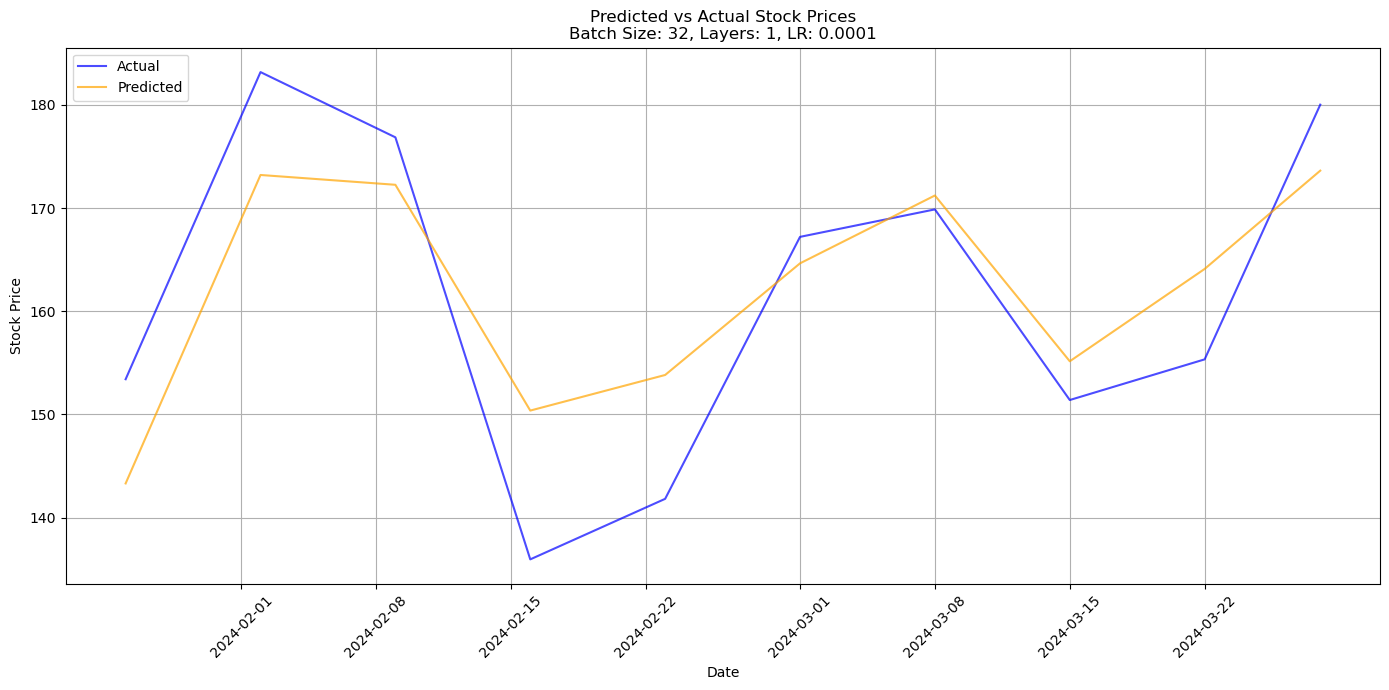

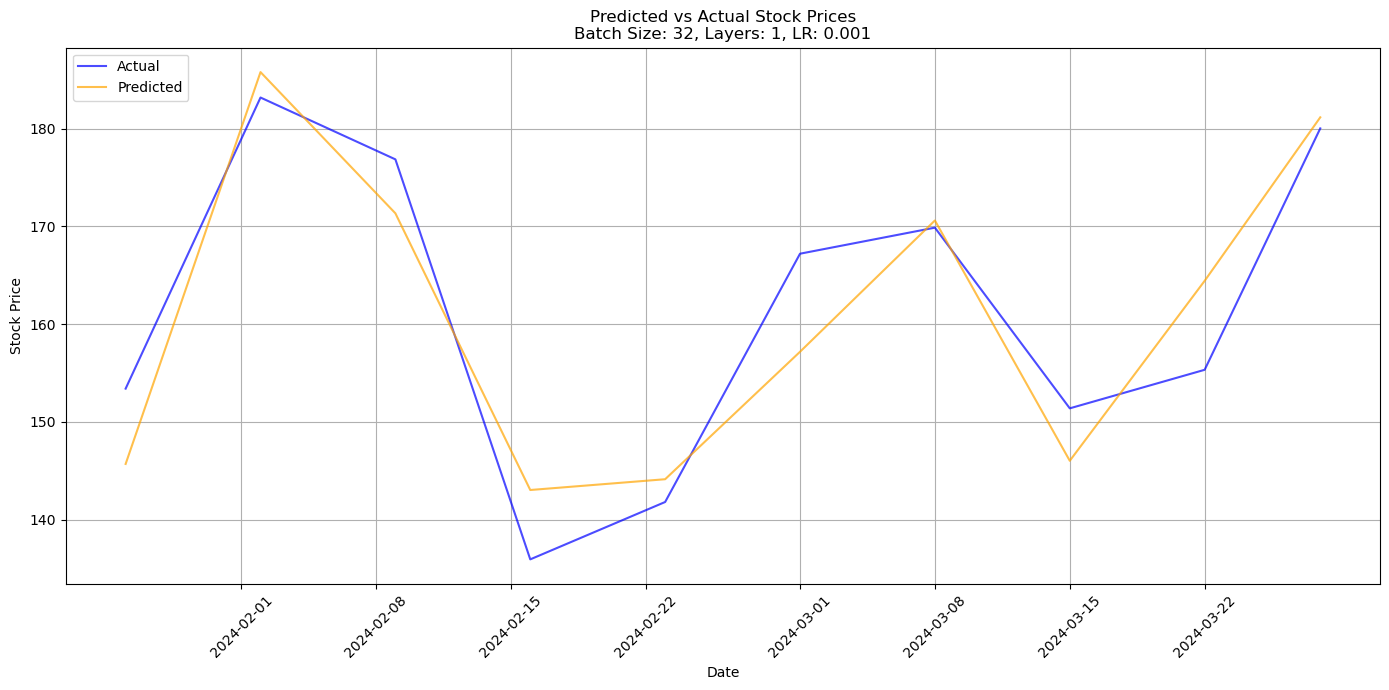

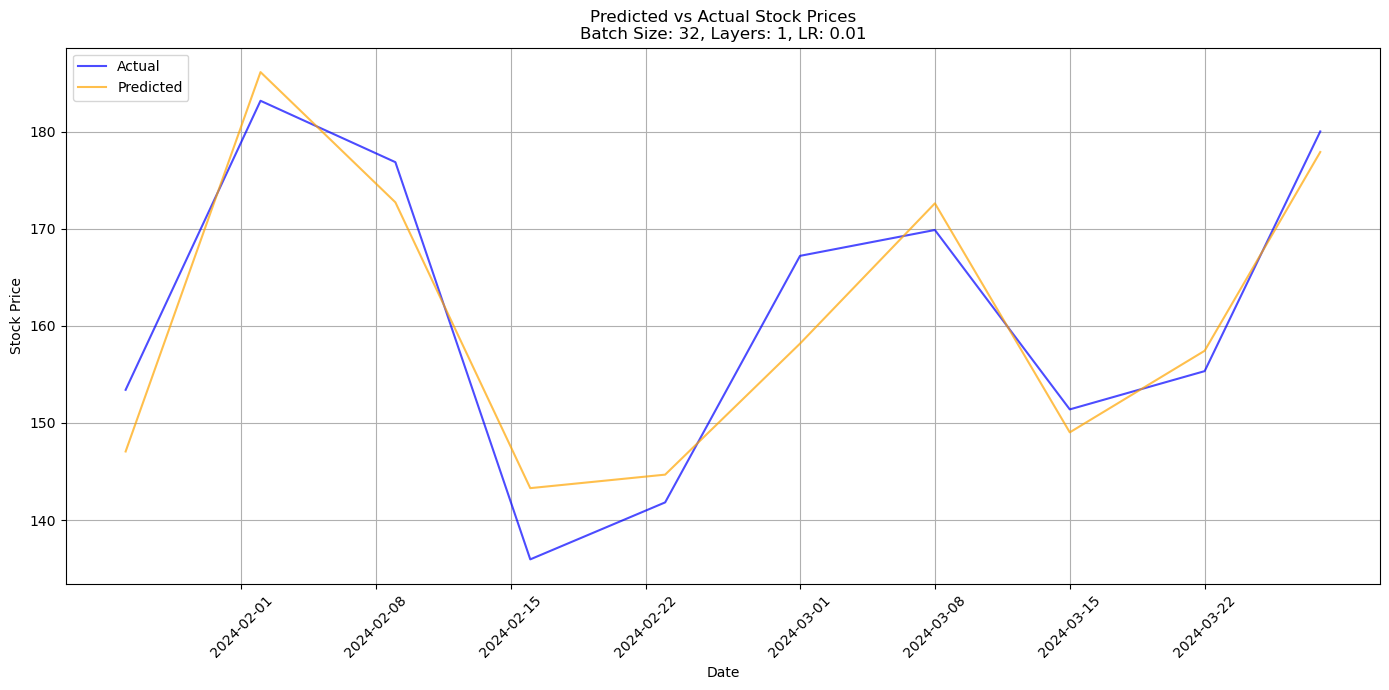

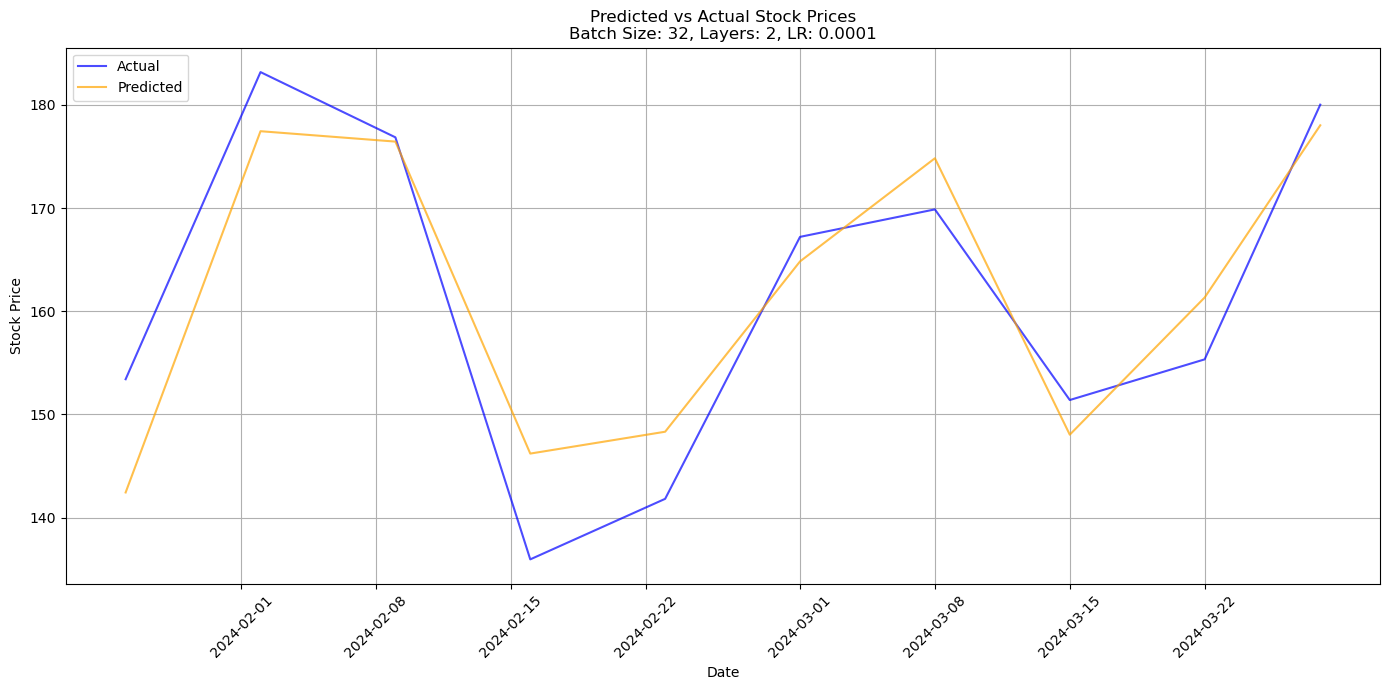

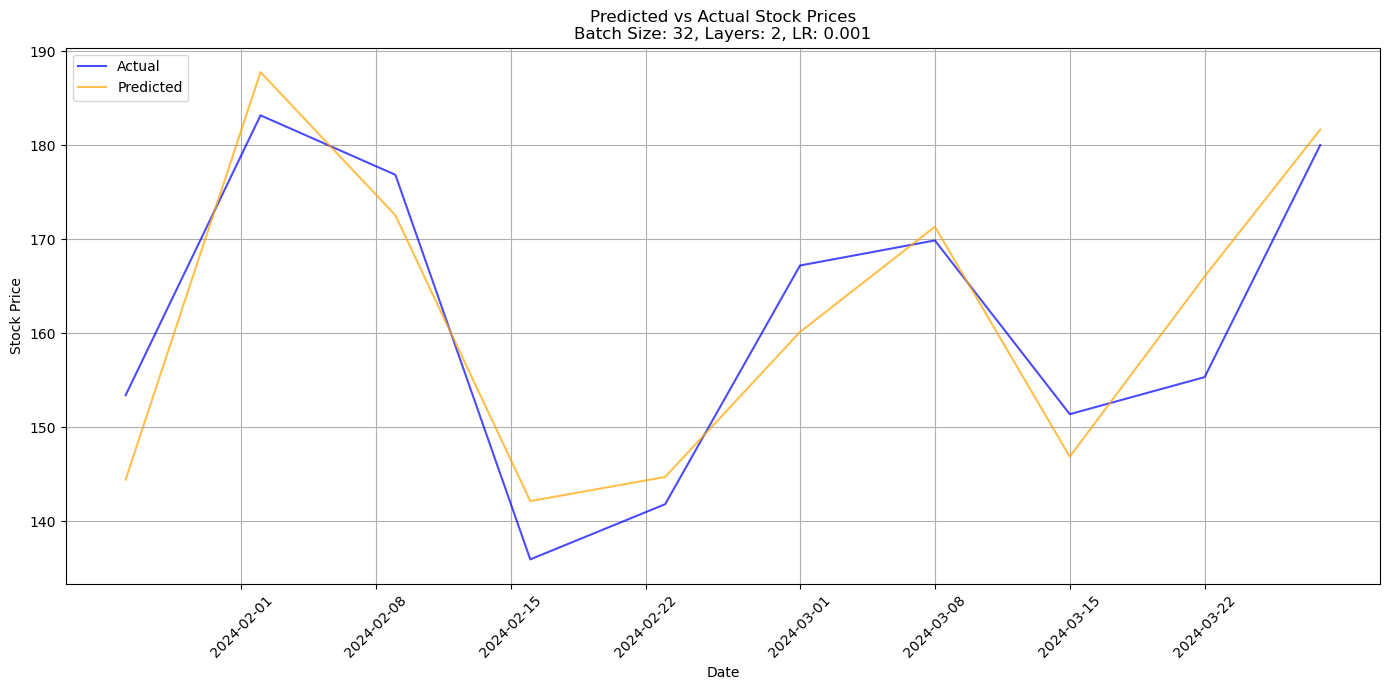

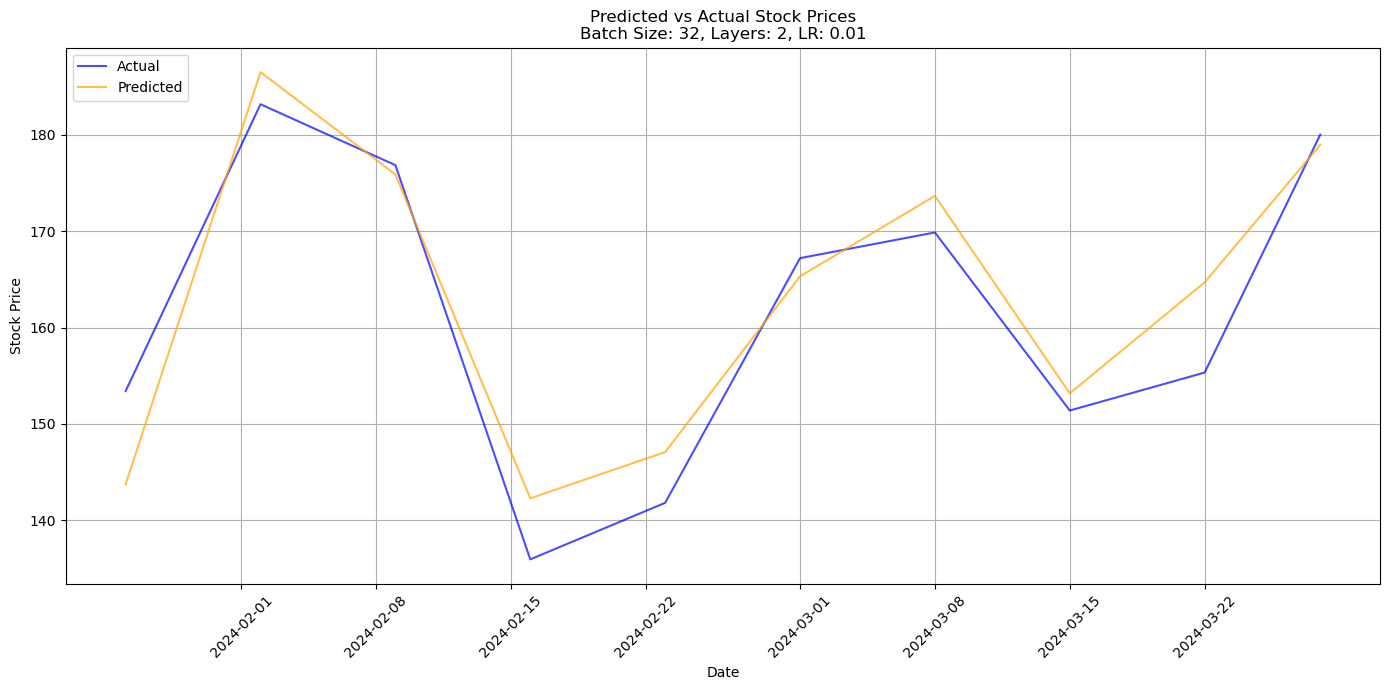

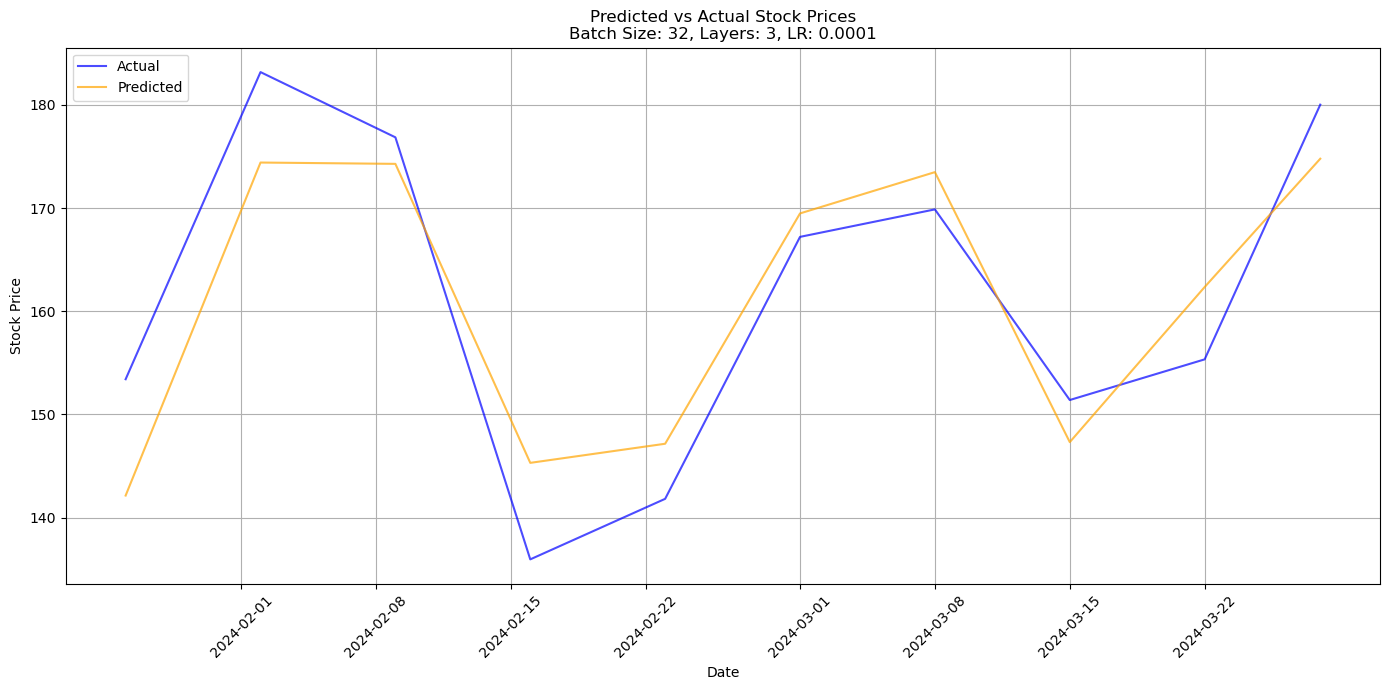

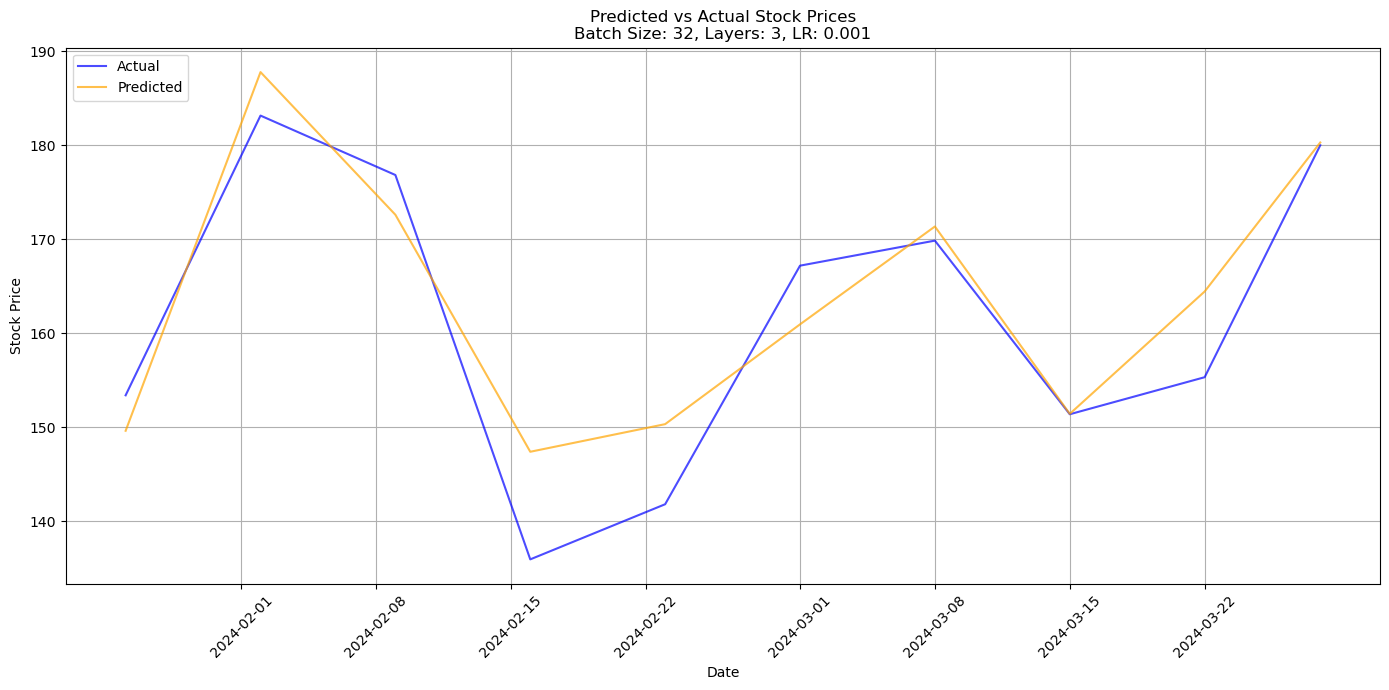

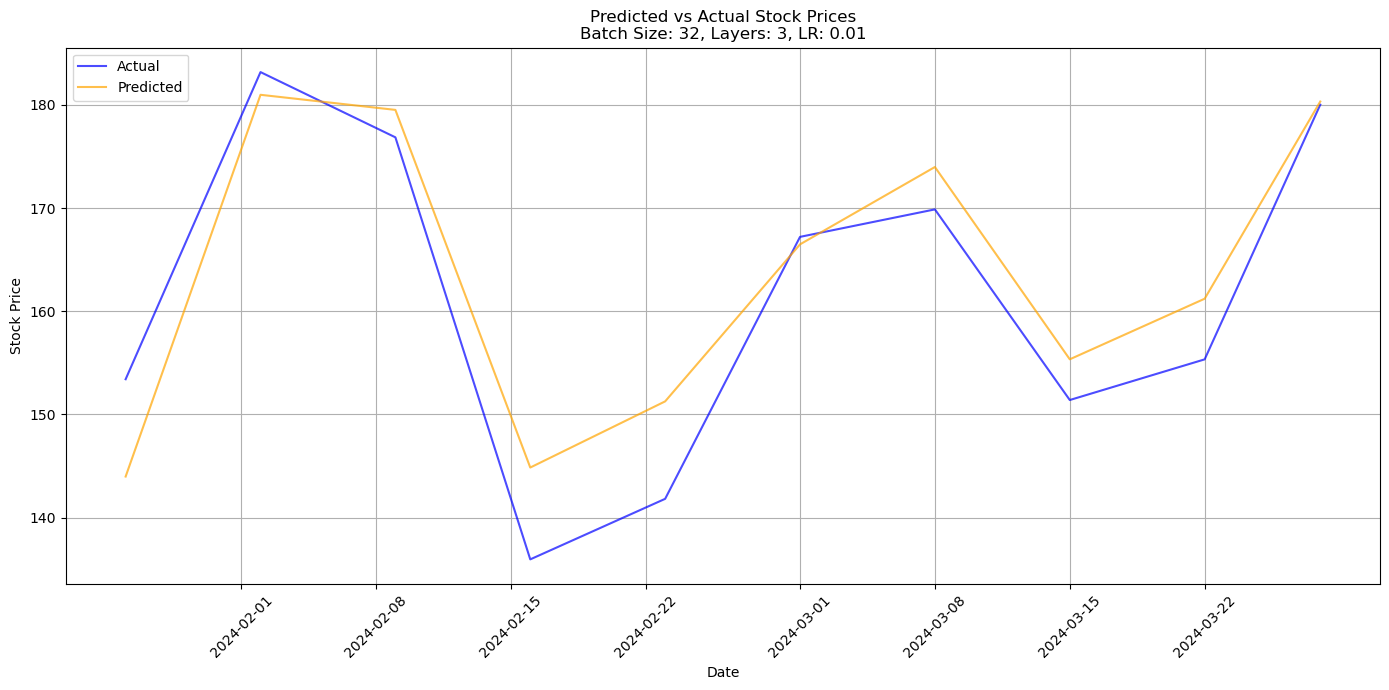

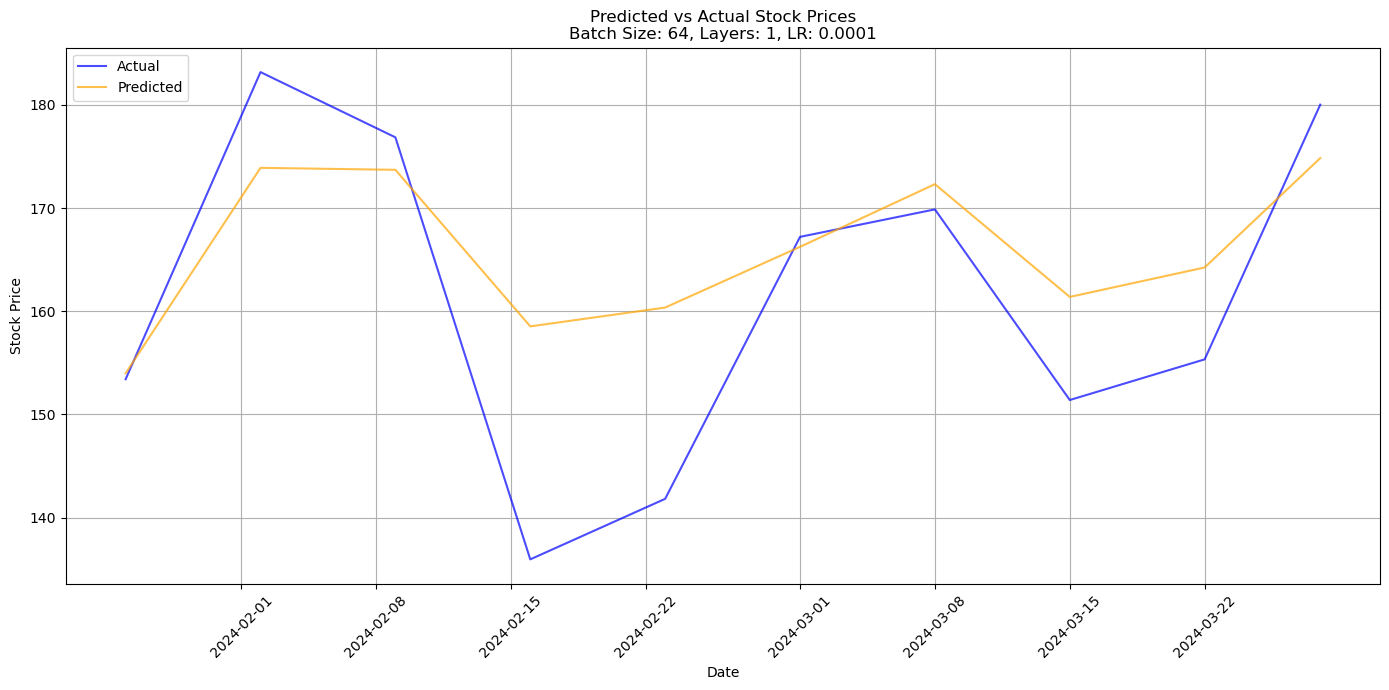

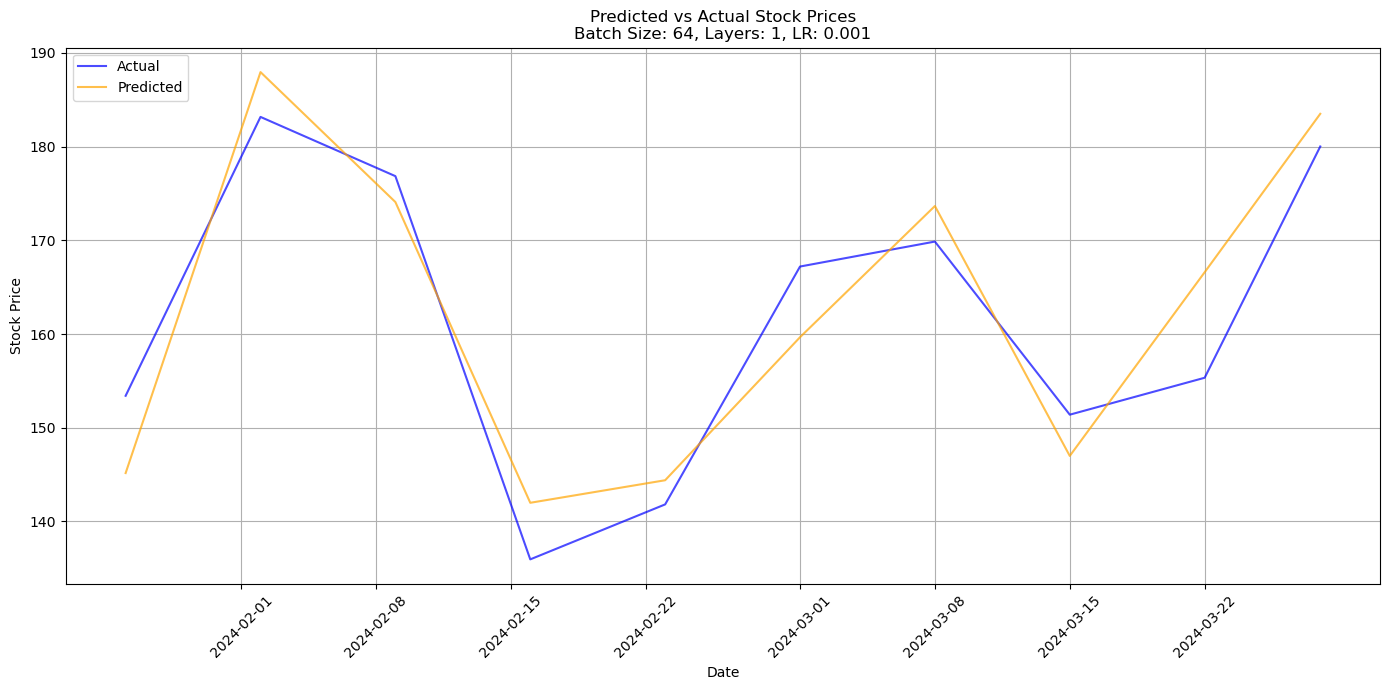

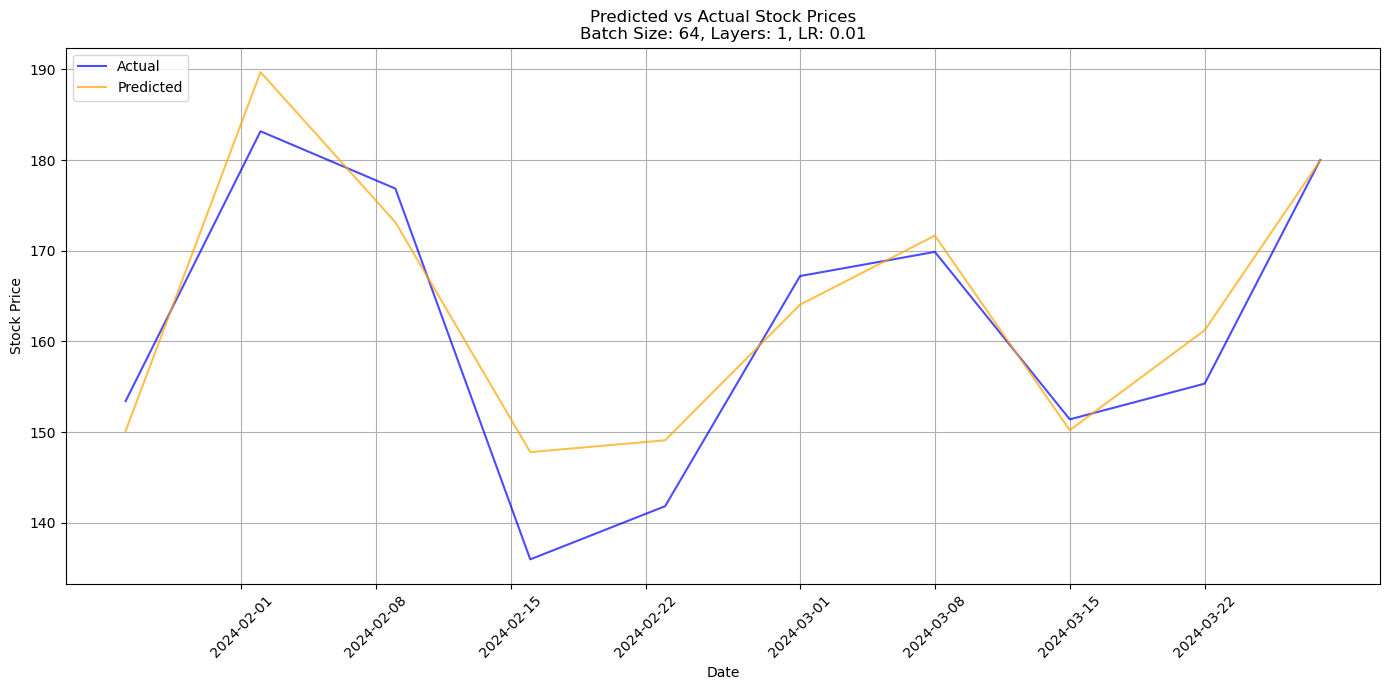

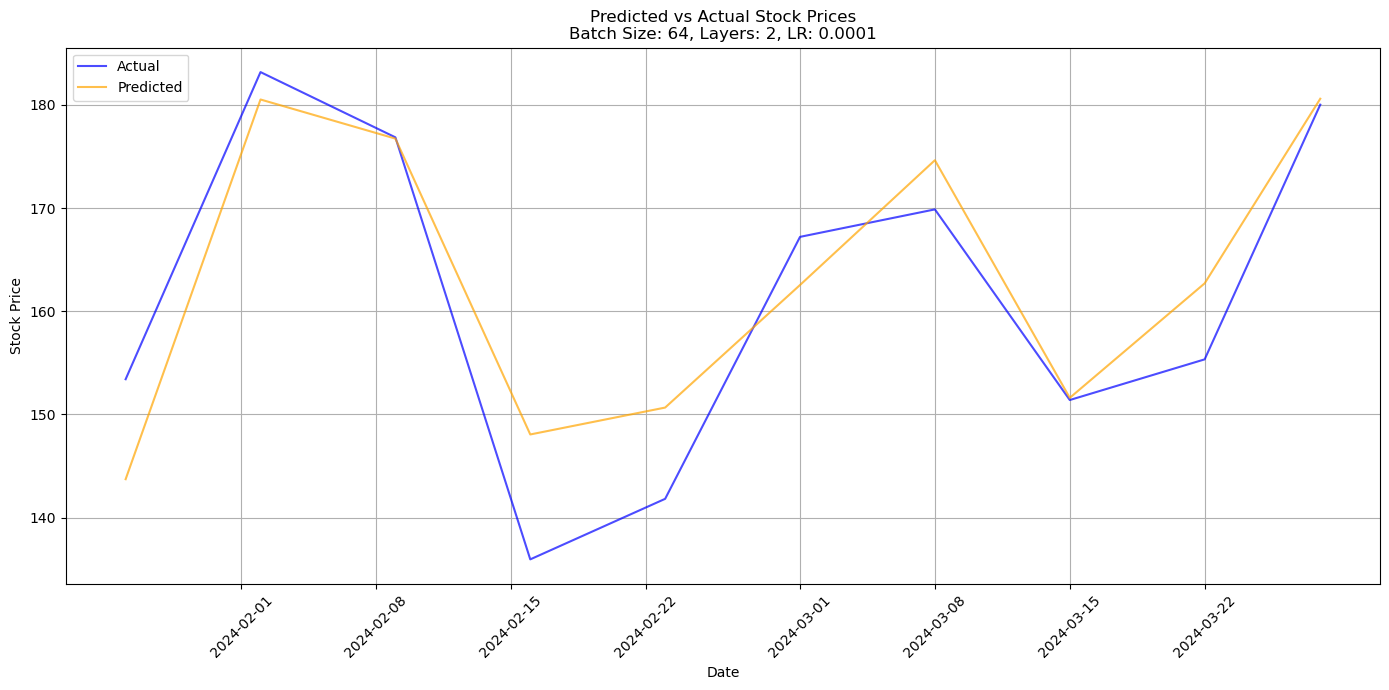

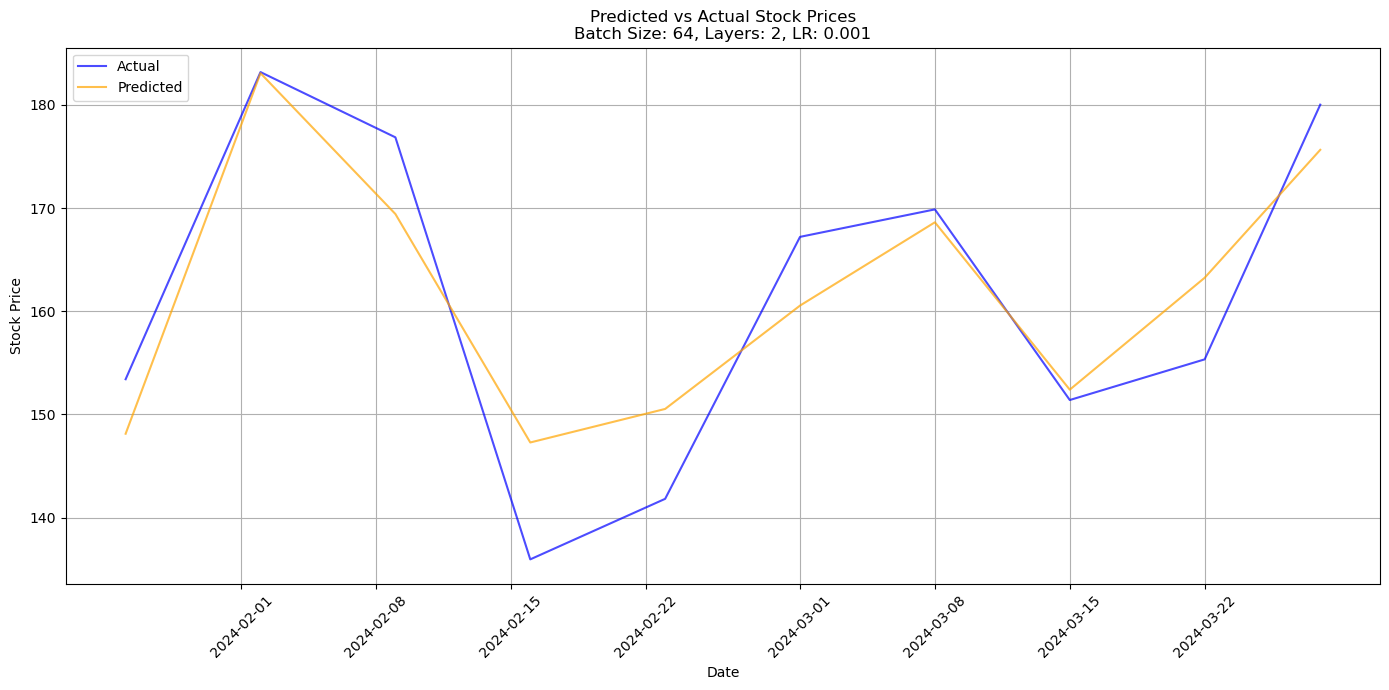

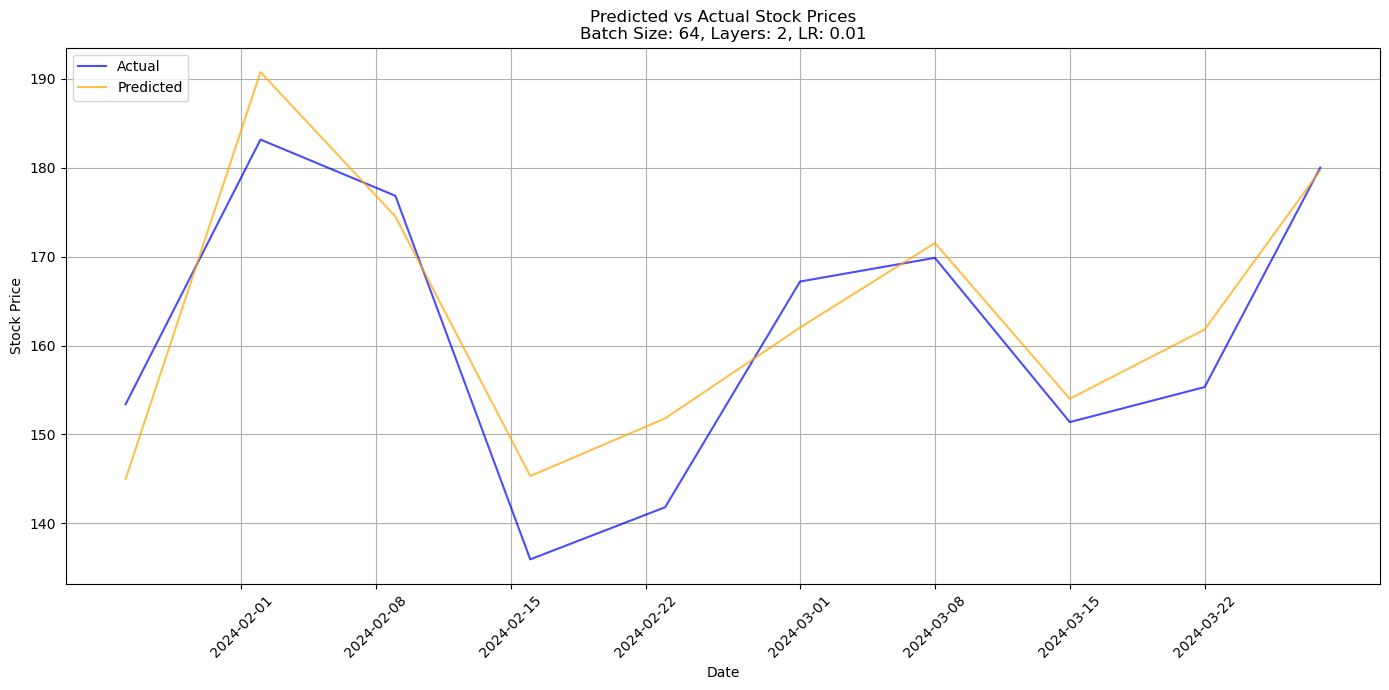

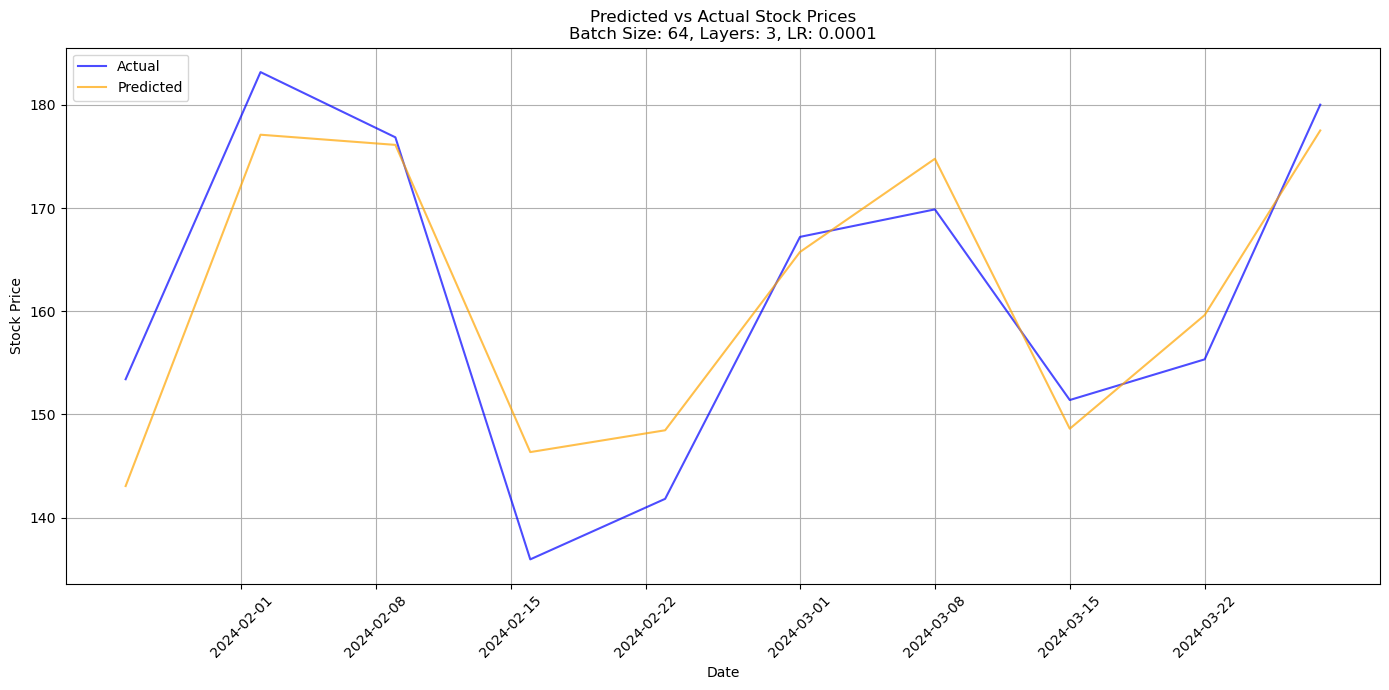

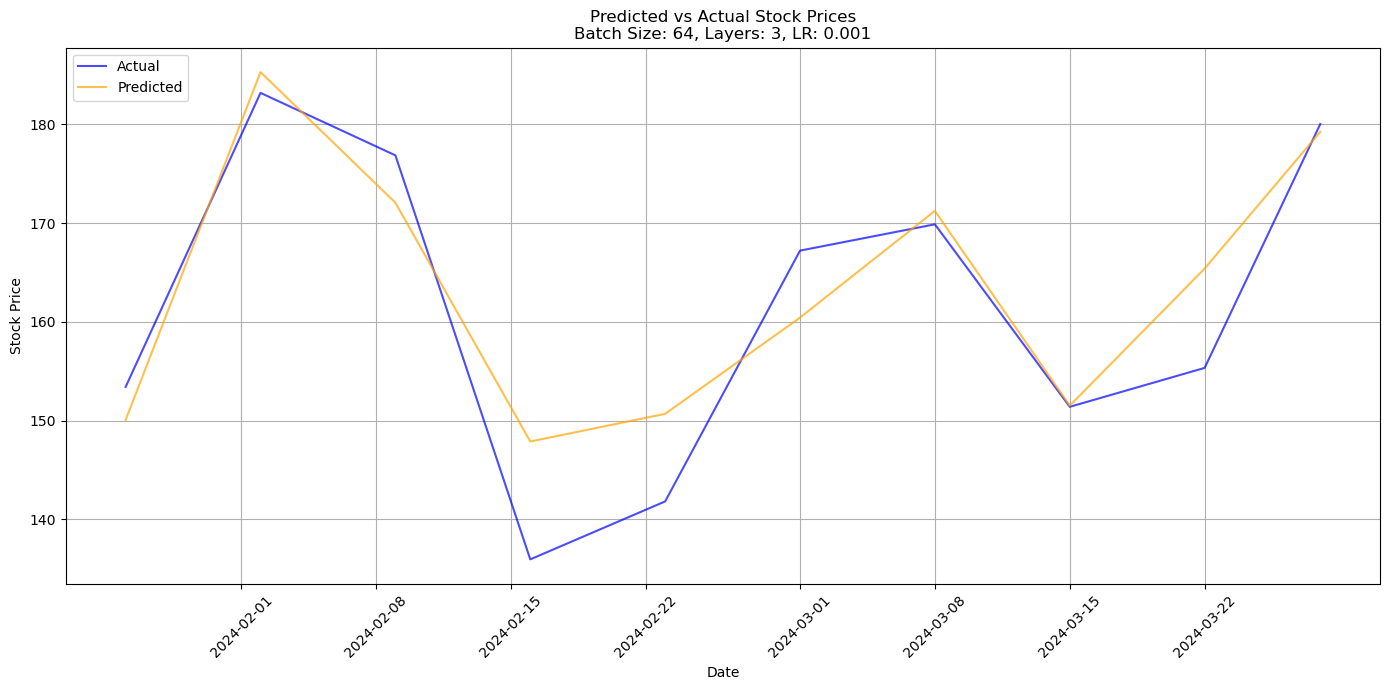

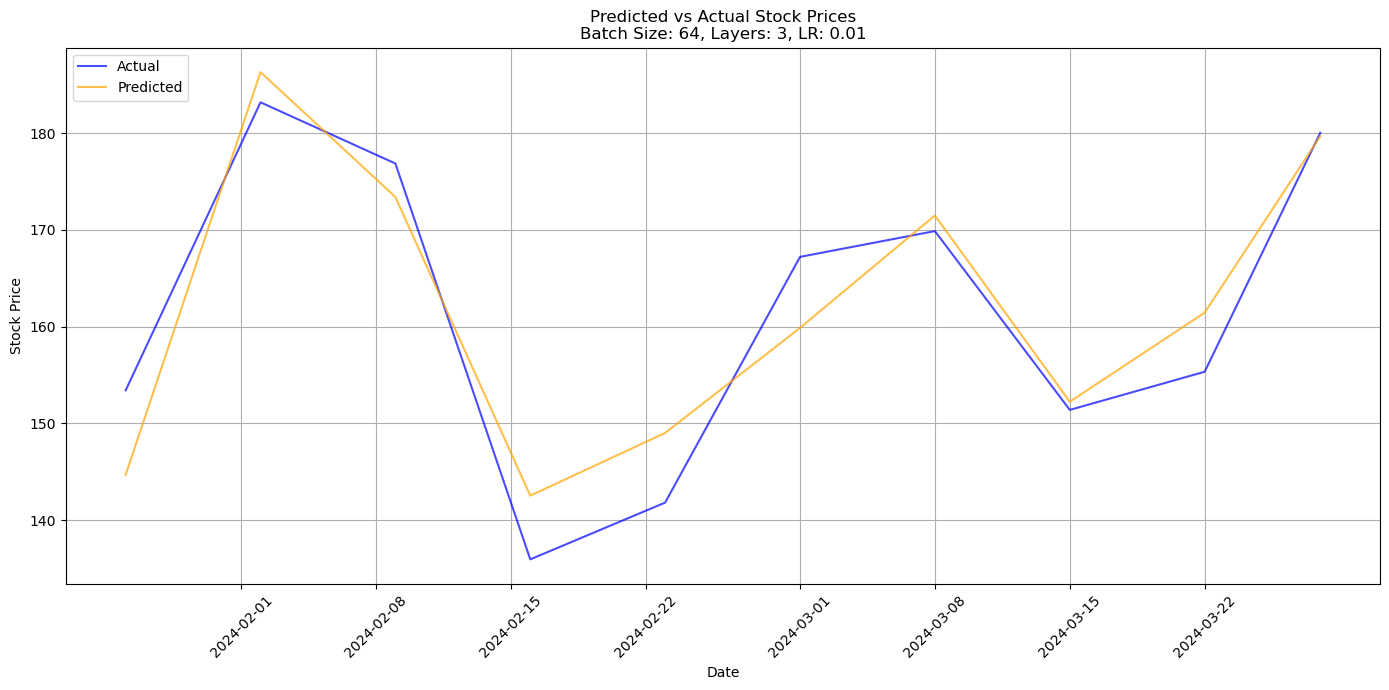

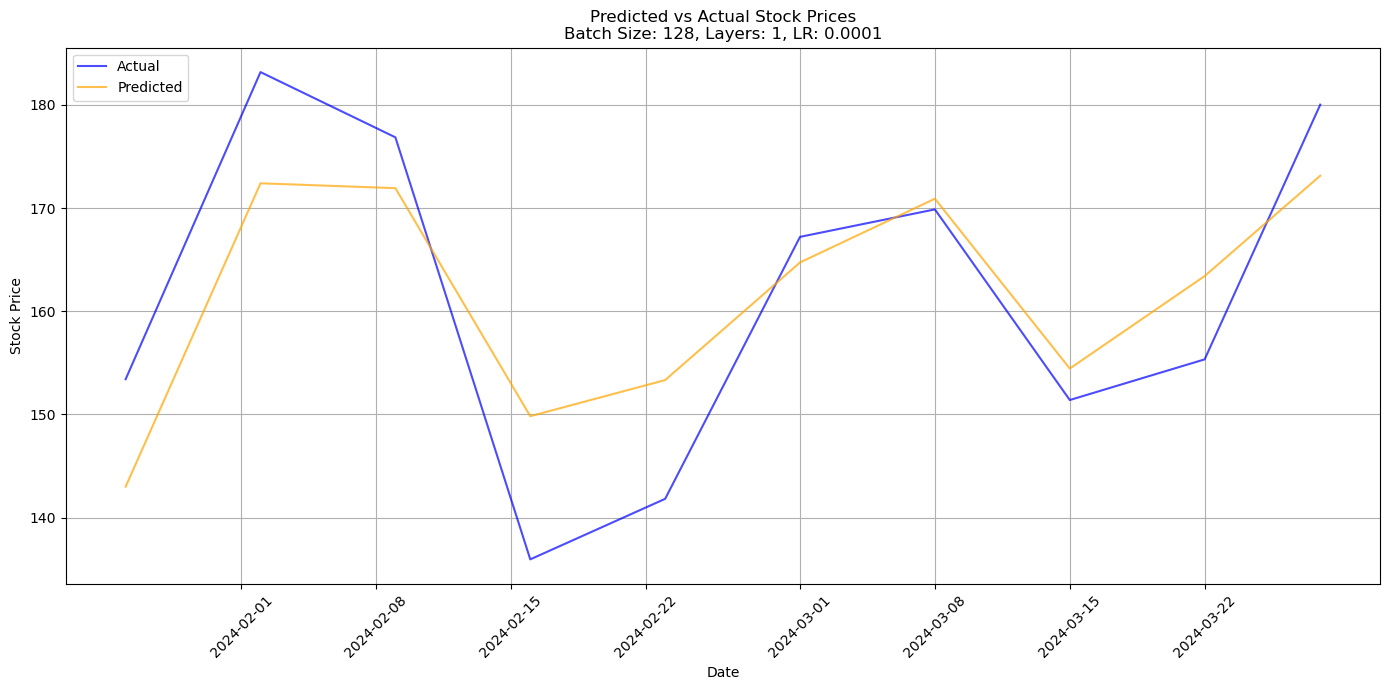

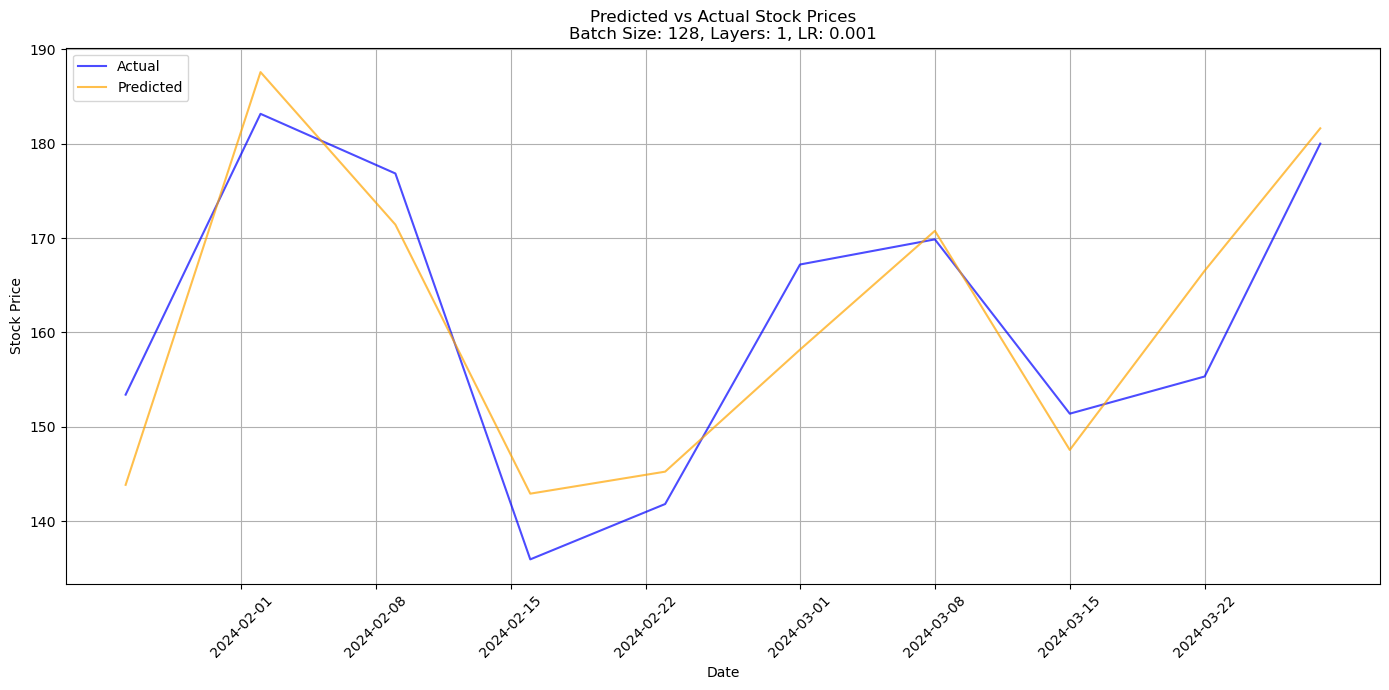

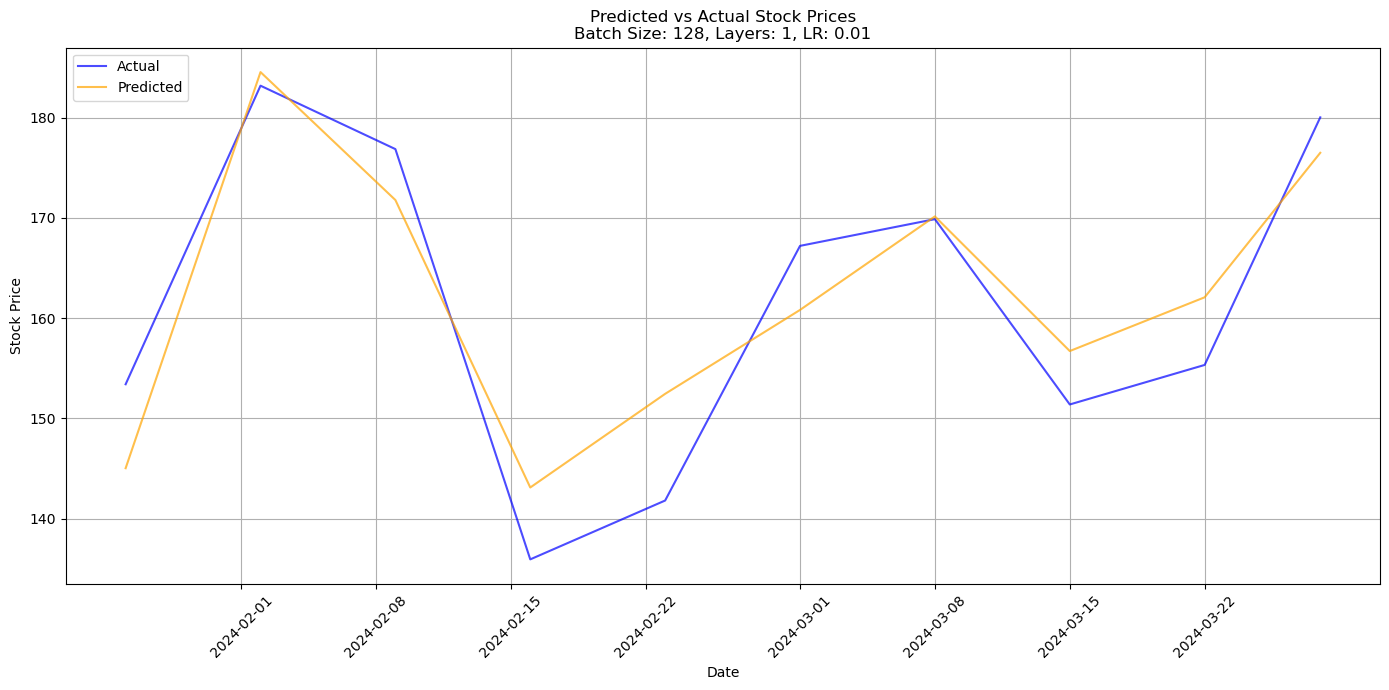

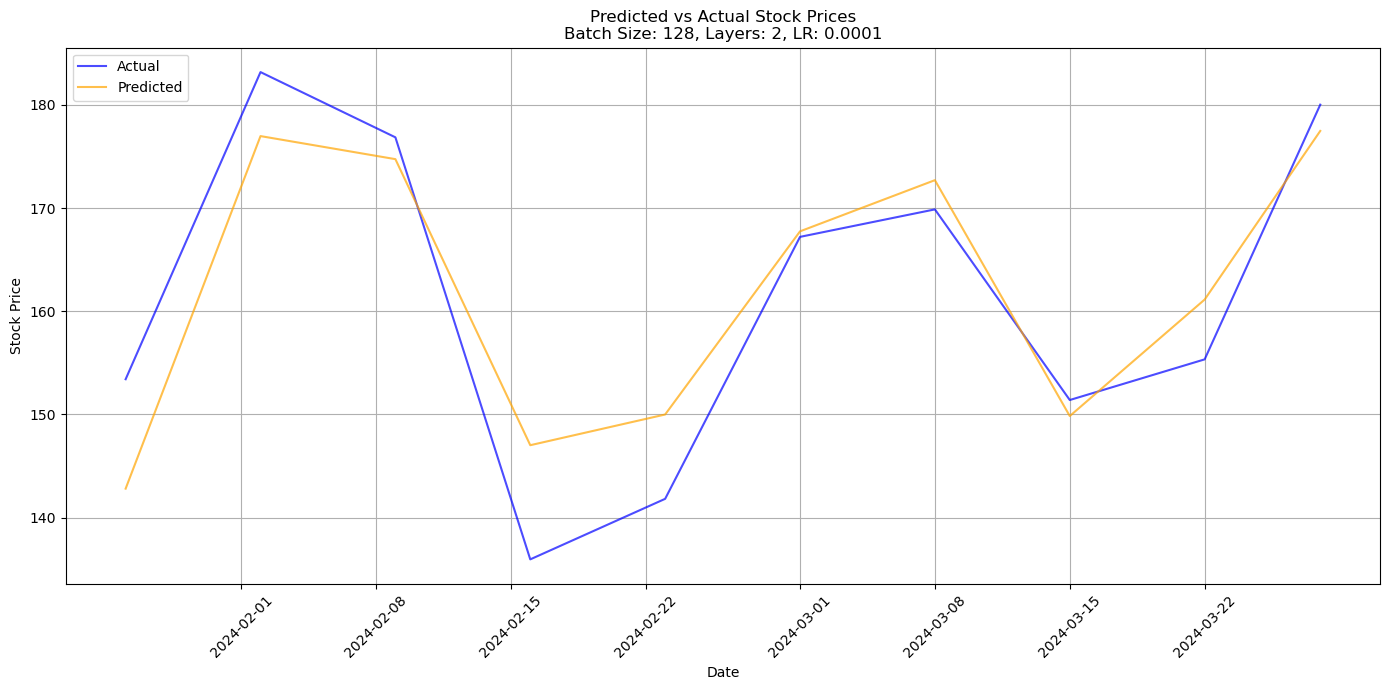

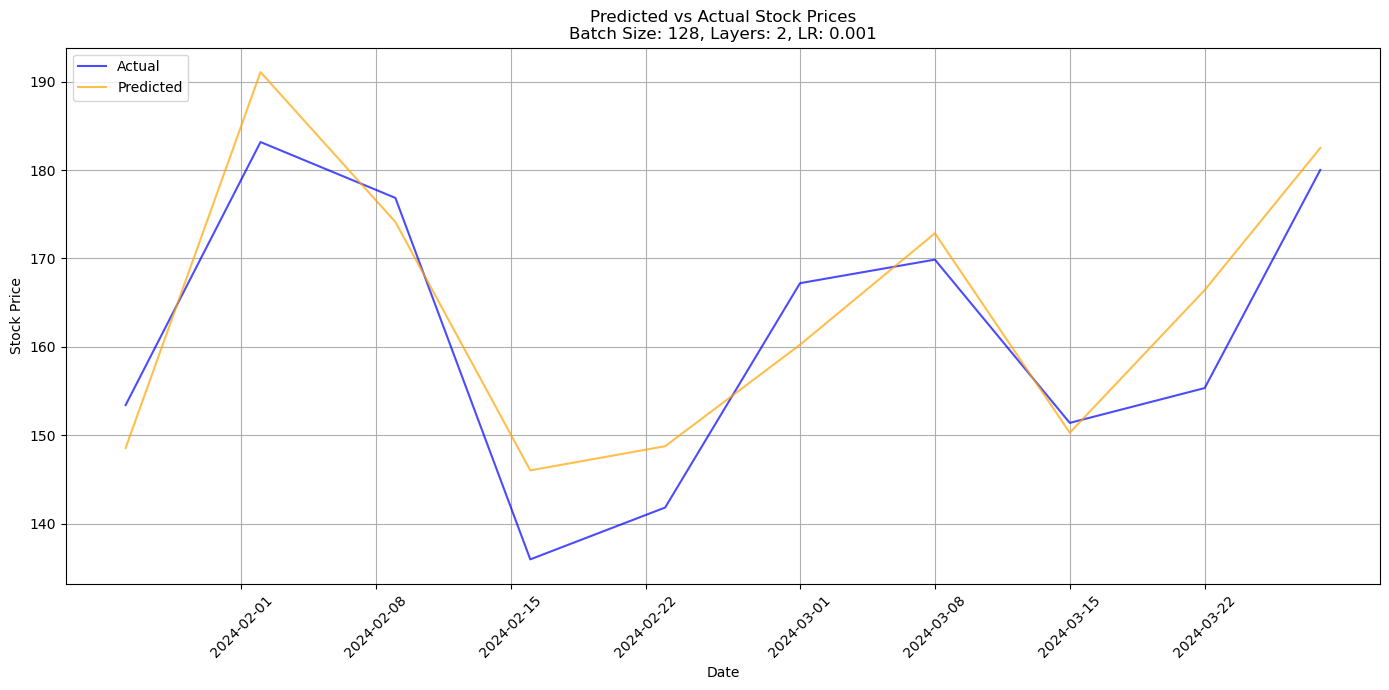

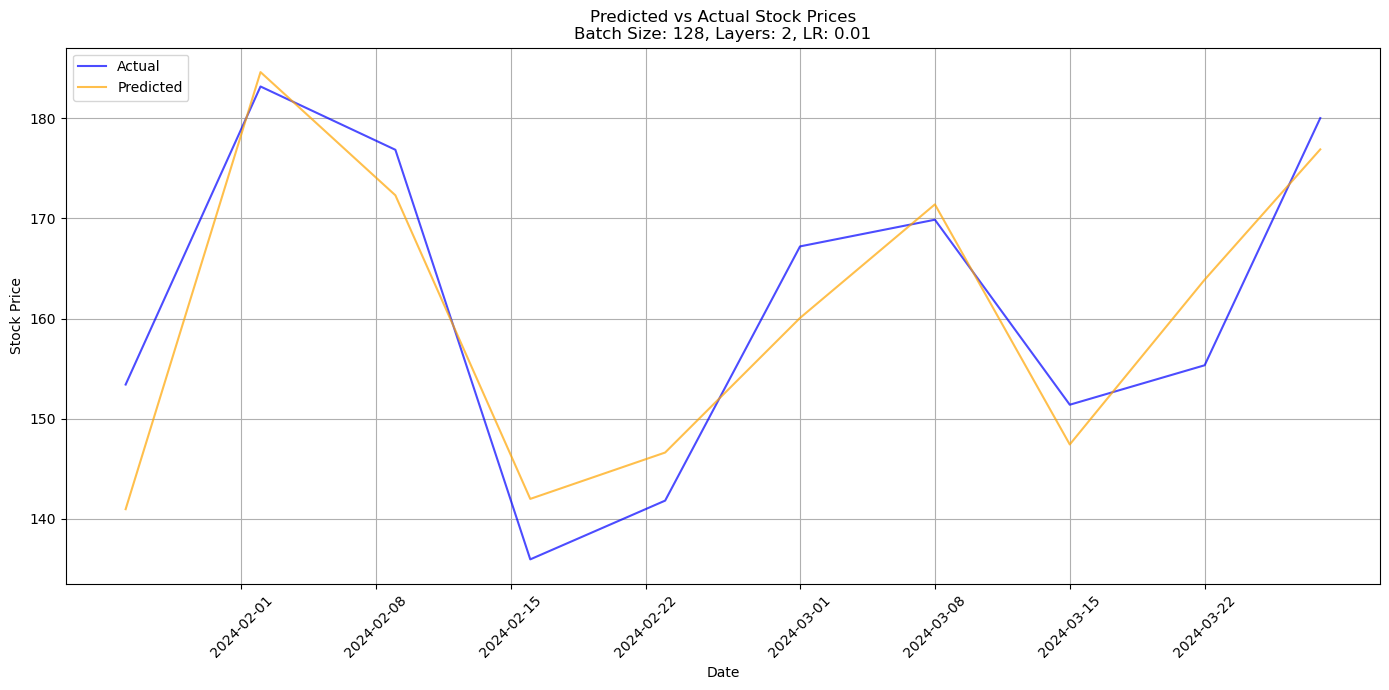

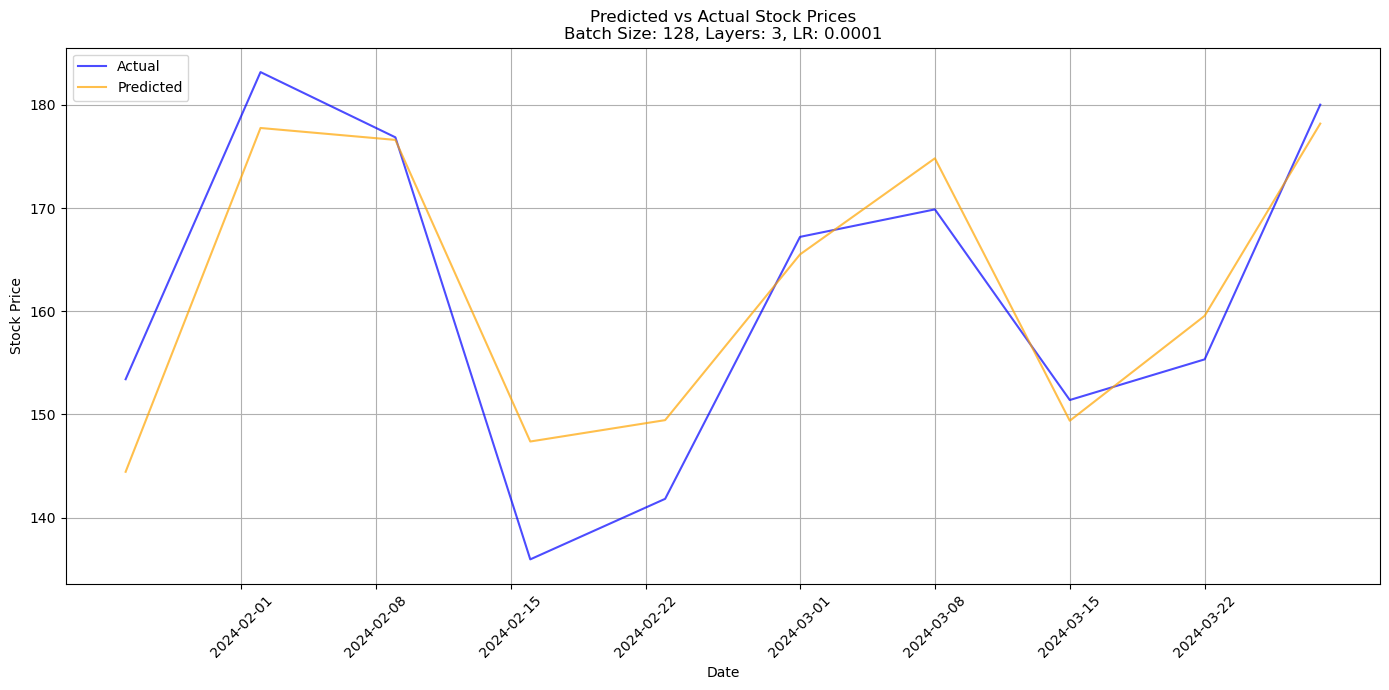

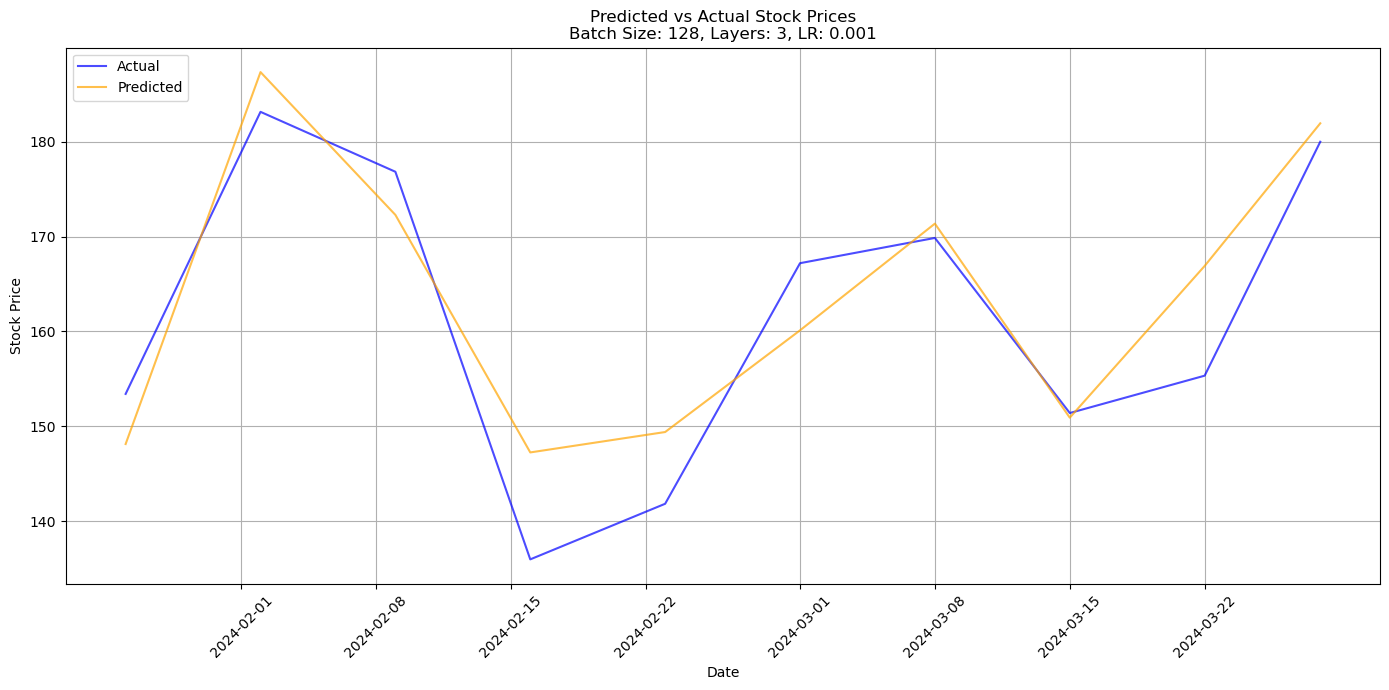

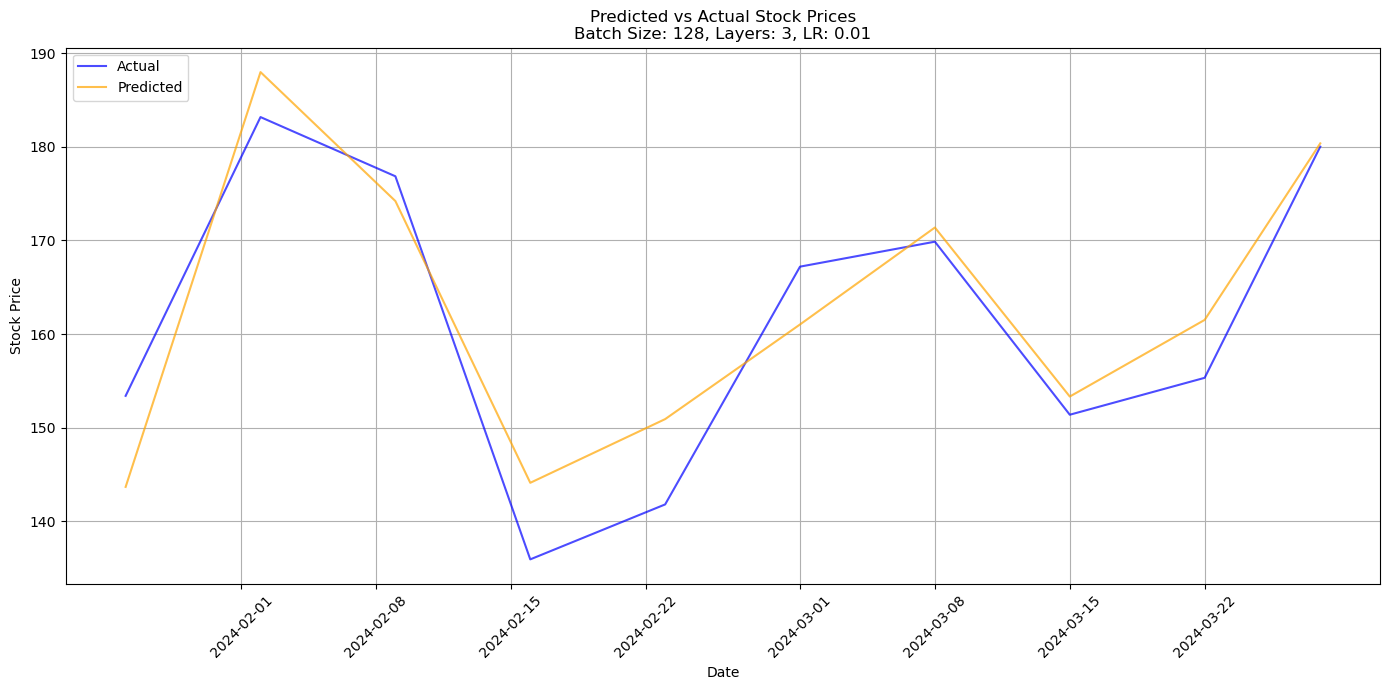

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Normalizer class (same as before)
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        x = np.array(x)
        self.mu = np.mean(x, axis=0, keepdims=True)
        self.sd = np.std(x, axis=0, keepdims=True)
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu

# Load and prepare data as in the previous cell


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Experimenting with varying the number of LSTM layers and learning rates
num_layers = [1, 2, 3]  # Number of LSTM layers
learning_rates = [0.0001, 0.001, 0.01]  # Learning rates to test
batch_sizes = [16, 32, 64, 128]  # Batch sizes to test

metrics = []
all_predictions = []

for layers in num_layers:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Define the model with the specified number of layers and learning rate
            model = tf.keras.Sequential()
            # Define the model with the specified number of layers and learning rate
           # model = Sequential()

            # Input layer with shape specification
            model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # No need for input_shape in Bidirectional
            
            # First LSTM layer (Bidirectional for the first layer)
            model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)), input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dropout(0.4))
            
            # Add additional LSTM layers as specified by `layers`
            for _ in range(layers - 1):
                model.add(LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
                model.add(Dropout(0.4))
            
            # Final LSTM layer (non-sequential for output)
            model.add(LSTM(50, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))
            model.add(Dropout(0.3))
            
            # Dense layers
            model.add(Dense(25, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
            model.add(Dense(1))  # Output layer
            
            # Compile the model with the specified learning rate
            optimizer = Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='Huber')
            
            # Callbacks for early stopping and learning rate decay
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)
            
            # Fit model
            model.fit(X_train, y_train, batch_size=batch_size, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, lr_scheduler])

            # Make predictions on the test set
            predictions = model.predict(X_test)

            # Inverse transform the predictions
            predictions_inv = normalizer.inverse_transform(np.column_stack((predictions, 
                                                                          np.zeros(predictions.shape), 
                                                                          np.zeros(predictions.shape), 
                                                                          np.zeros(predictions.shape), 
                                                                          np.zeros(predictions.shape), 
                                                                          np.zeros(predictions.shape), 
                                                                          np.zeros(predictions.shape))))[:, 0]

            # Inverse transform the test values
            y_test_scaled = normalizer.inverse_transform(np.column_stack((y_test.reshape(-1, 1), 
                                                                           np.zeros(y_test.shape), 
                                                                           np.zeros(y_test.shape), 
                                                                           np.zeros(y_test.shape), 
                                                                           np.zeros(y_test.shape), 
                                                                           np.zeros(y_test.shape), 
                                                                           np.zeros(y_test.shape))))[:, 0]

            # Calculate performance metrics
            rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions_inv))
            mae = mean_absolute_error(y_test_scaled, predictions_inv)
            mape = np.mean(np.abs((y_test_scaled - predictions_inv) / y_test_scaled)) * 100
            da = np.mean(np.sign(y_test_scaled[1:] - y_test_scaled[:-1]) == np.sign(predictions_inv[1:] - predictions_inv[:-1]))

            metrics.append({
                'Num Layers': layers,
                'Learning Rate': lr,
                'Batch Size': batch_size,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'DA': da
            })

            all_predictions.append({
                'Num Layers': layers,
                'Learning Rate': lr,
                'Batch Size': batch_size,
                'Actual': y_test_scaled,
                'Predicted': predictions_inv
            })

# Convert metrics into DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

# Print the performance metrics DataFrame
print("Performance Metrics DataFrame:")
print(metrics_df)

# Plot error metrics for each batch size, learning rate, and number of layers combination
plt.figure(figsize=(14, 8))

# RMSE Plot
plt.subplot(2, 2, 1)
for (layers, lr) in zip(num_layers, learning_rates):
    subset = metrics_df[(metrics_df['Num Layers'] == layers) & (metrics_df['Learning Rate'] == lr)]
    plt.plot(subset['Batch Size'], subset['RMSE'], label=f'{layers} layers, LR={lr}')
plt.title('RMSE for Different Batch Sizes, Layers, and Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.legend()

# MAE Plot
plt.subplot(2, 2, 2)
for (layers, lr) in zip(num_layers, learning_rates):
    subset = metrics_df[(metrics_df['Num Layers'] == layers) & (metrics_df['Learning Rate'] == lr)]
    plt.plot(subset['Batch Size'], subset['MAE'], label=f'{layers} layers, LR={lr}')
plt.title('MAE for Different Batch Sizes, Layers, and Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('MAE')
plt.legend()

# MAPE Plot
plt.subplot(2, 2, 3)
for (layers, lr) in zip(num_layers, learning_rates):
    subset = metrics_df[(metrics_df['Num Layers'] == layers) & (metrics_df['Learning Rate'] == lr)]
    plt.plot(subset['Batch Size'], subset['MAPE'], label=f'{layers} layers, LR={lr}')
plt.title('MAPE for Different Batch Sizes, Layers, and Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('MAPE (%)')
plt.legend()

# Directional Accuracy Plot
plt.subplot(2, 2, 4)
for (layers, lr) in zip(num_layers, learning_rates):
    subset = metrics_df[(metrics_df['Num Layers'] == layers) & (metrics_df['Learning Rate'] == lr)]
    plt.plot(subset['Batch Size'], subset['DA'], label=f'{layers} layers, LR={lr}')
plt.title('Directional Accuracy for Different Batch Sizes, Layers, and Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('Directional Accuracy')
plt.legend()

# Adjust layout to prevent overlaps
plt.tight_layout()
plt.show()

# Plot predicted vs actual values for each batch size, learning rate, and number of layers combination
for batch_size in batch_sizes:
    for layers in num_layers:
        for lr in learning_rates:
            prediction_data = next(item for item in all_predictions if item['Batch Size'] == batch_size and item['Num Layers'] == layers and item['Learning Rate'] == lr)
            
            predicted_values = prediction_data['Predicted']
            actual_values = prediction_data['Actual']
            
            # Extract corresponding dates for the actual values
            dates = combined_df['Date'].values[-len(actual_values):]
            
            # Plot predicted vs actual values
            plt.figure(figsize=(14, 7))
            plt.plot(dates, actual_values, label='Actual', color='blue', alpha=0.7)
            plt.plot(dates, predicted_values, label='Predicted', color='orange', alpha=0.7)
            
            plt.title(f'Predicted vs Actual Stock Prices\nBatch Size: {batch_size}, Layers: {layers}, LR: {lr}')
            plt.xlabel('Date')
            plt.ylabel('Stock Price')
            plt.xticks(rotation=45)
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.tight_layout()
            plt.show()


In [49]:
scaler.inverse_transform(X_test)

NameError: name 'scaler' is not defined

#### Capture the predictions in data frame and combine with Ridge model

In [75]:
X_in= X.reshape(X.shape[0], X.shape[1], 1)
lstm_pred=model.predict(X_in)
lstm_pred_scaled=scaler.inverse_transform(lstm_pred)
result_df['lstm_predicted']=lstm_pred_scaled

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [76]:
result_df

lag_40    lag_39    lag_38    lag_37    lag_36    lag_35    lag_34  \
0     27.0901   26.4646   26.7389   25.7454   26.3314   25.8726   25.9673   
1     26.4646   26.7389   25.7454   26.3314   25.8726   25.9673   27.5669   
2     26.7389   25.7454   26.3314   25.8726   25.9673   27.5669   27.9255   
3     25.7454   26.3314   25.8726   25.9673   27.5669   27.9255   27.7479   
4     26.3314   25.8726   25.9673   27.5669   27.9255   27.7479   27.5200   
..        ...       ...       ...       ...       ...       ...       ...   
500  130.0486  133.7295  136.6024  137.8793  132.9913  136.3032  133.5101   
501  133.7295  136.6024  137.8793  132.9913  136.3032  133.5101  142.3682   
502  136.6024  137.8793  132.9913  136.3032  133.5101  142.3682  140.5826   
503  137.8793  132.9913  136.3032  133.5101  142.3682  140.5826  137.0513   
504  132.9913  136.3032  133.5101  142.3682  140.5826  137.0513  143.8844   

       lag_33    lag_32    lag_31  ...     lag_6     lag_5     lag_4  \
0     27.5669   27.9255   27.7479  ...   27.0247   26.1983   25.8691   
1     27.9255   27.7479   27.5200  ...   26.1983   25.8691   25.7539   
2     27.7479   27.5200   27.7494  ...   25.8691   25.7539   26.6357   
3     27.5200   27.7494   28.7909  ...   25.7539   26.6357   26.1758   
4     27.7494   28.7909   29.1644  ...   26.6357   26.1758   24.7473   
..        ...       ...       ...  ...       ...       ...       ...   
500  142.3682  140.5826  137.0513  ...  183.1750  191.7036  186.5305   
501  140.5826  137.0513  143.8844  ...  191.7036  186.5305  179.1504   
502  137.0513  143.8844  147.6052  ...  186.5305  179.1504  168.4547   
503  143.8844  147.6052  153.4109  ...  179.1504  168.4547  168.1751   
504  147.6052  153.4109  143.1861  ...  168.4547  168.1751  165.1691   

        lag_3     lag_2     lag_1  observed  ridge_predicted  earnings  \
0     25.7539   26.6357   26.1758   27.9489        21.421546  -94.9842   
1     26.6357   26.1758   24.7473   27.3494        19.772393  -94.9842   
2     26.1758   24.7473   25.3414   26.7105        20.216163  -94.9842   
3     24.7473   25.3414   26.9309   26.9339        21.323598  -95.0361   
4     25.3414   26.9309   26.6601   26.1379        21.287356  -95.0361   
..        ...       ...       ...       ...              ...       ...   
500  179.1504  168.4547  168.1751  165.0500       175.204434    2.7174   
501  168.4547  168.1751  165.1691  166.9900       173.567499    2.7174   
502  168.1751  165.1691  164.5200  172.6500       168.078317    2.7174   
503  165.1691  164.5200  167.2064  179.8600       170.488361    2.7174   
504  164.5200  167.2064  164.8895  177.3500       161.956863    2.7174   

     lstm_predicted  
0         29.585438  
1         29.469345  
2         29.390123  
3         29.423204  
4         29.459030  
..              ...  
500      151.137665  
501      149.591782  
502      147.929871  
503      146.466690  
504      144.857544  

[505 rows x 44 columns]

In [77]:
from xgboost import XGBRFRegressor
model = XGBRFRegressor(use_label_encoder=False, eval_metric='logloss')

model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[09:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [78]:
y_pred=model.predict(X)
y_pred_inv_scaled=scaler.inverse_transform(np.reshape(y_pred,[-1,1]))
y_pred_inv_scaled.reshape(1,-1)[0]
result_df['xgb_predicted']=y_pred_inv_scaled.reshape(1,-1)[0]

#### utility method to get metrics across multiple moodel

In [80]:

def accuracy(df_forecast, y_train_series, seasonallity):

    method = df_forecast.columns[1:]
    rmse_results = []
    mae_results = []
    mape_results = []
    mase_results = []
    dir_accuracy_results=[]
    
    def directional_accuracy(y_true, y_pred):
    # Compare directions of changes
        y_true_dir = np.sign(np.diff(y_true))
        y_pred_dir = np.sign(np.diff(y_pred))
        return np.mean(y_true_dir == y_pred_dir)

    y = df_forecast.observed.values
    scale = np.abs(y_train_series[:-seasonallity] - y_train_series[seasonallity:])
    scale = np.average(scale)

    for i in method:
        y_hat = df_forecast[i].values
        d = y - y_hat
        mae_f = np.mean(abs(d))
        rmse_f = np.sqrt(np.mean(d**2))
        mape = np.mean(np.abs(d/y))*100
        mase = mae_f / scale
        dir_accuracy=directional_accuracy(y,y_hat)
        mae_results.append(np.round(mae_f,2))
        rmse_results.append(np.round(rmse_f,2))
        mape_results.append(np.round(mape,2))
        mase_results.append(np.round(mase,2))
        dir_accuracy_results.append(np.round(dir_accuracy,2))

    accuracy_df = pd.DataFrame({'Method':method,
                    'RMSE':rmse_results,
                    'MAE':mae_results,
                    'MAPE':mape_results,
                    'MASE':mase_results,
                   'DA':dir_accuracy_results })

    return accuracy_df

#### Compare the performance of the models

* DA - Directional Accuracy 
    * All the models have accuracy < 0.5 except xgboost
    * still Not a great fit

In [90]:

accuracy(result_df[['observed','lag_1','ridge_predicted','lstm_predicted','xgb_predicted']], result_df['observed'].values, time_step)

Method   RMSE   MAE  MAPE  MASE    DA
0            lag_1  10.42  7.57  8.73  0.41  0.52
1  ridge_predicted   9.67  7.07  9.02  0.38  0.54
2   lstm_predicted  10.31  5.84  6.52  0.31  0.53
3    xgb_predicted  14.59  5.03  3.92  0.27  0.74

#### Visualizing all the model predictions

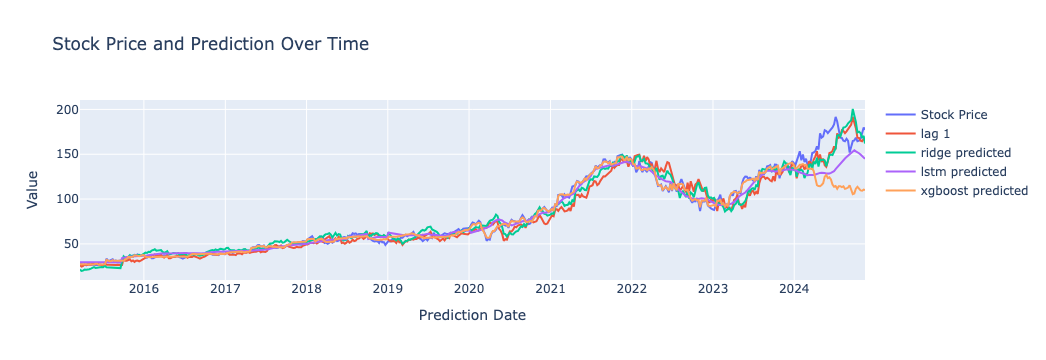

In [93]:
import plotly.express as px
import plotly.graph_objects as go
future_days=10
trace1 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['observed'], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['lag_1'], mode='lines', name='lag 1')
trace3 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['ridge_predicted'], mode='lines', name='ridge predicted')
trace4 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['lstm_predicted'], mode='lines', name='lstm predicted')
trace5 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['xgb_predicted'], mode='lines', name='xgboost predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and Prediction Over Time',
    xaxis=dict(title='Prediction Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2,trace3,trace4,trace5], layout=layout)

# Show the plot
fig.show()

In [96]:
len(df_stock.index[time_step+future_days:]),len(result_df['observed'])


(505, 505)

In [98]:
result_df.tail(20)

lag_40    lag_39    lag_38    lag_37    lag_36    lag_35    lag_34  \
485  120.0134  132.6821  128.2231  129.8491  127.7942  130.3678  136.4628   
486  132.6821  128.2231  129.8491  127.7942  130.3678  136.4628  136.8618   
487  128.2231  129.8491  127.7942  130.3678  136.4628  136.8618  137.9591   
488  129.8491  127.7942  130.3678  136.4628  136.8618  137.9591  130.9264   
489  127.7942  130.3678  136.4628  136.8618  137.9591  130.9264  131.5250   
490  130.3678  136.4628  136.8618  137.9591  130.9264  131.5250  138.3880   
491  136.4628  136.8618  137.9591  130.9264  131.5250  138.3880  138.2384   
492  136.8618  137.9591  130.9264  131.5250  138.3880  138.2384  136.4029   
493  137.9591  130.9264  131.5250  138.3880  138.2384  136.4029  123.0958   
494  130.9264  131.5250  138.3880  138.2384  136.4029  123.0958  130.0486   
495  131.5250  138.3880  138.2384  136.4029  123.0958  130.0486  133.7295   
496  138.3880  138.2384  136.4029  123.0958  130.0486  133.7295  136.6024   
497  138.2384  136.4029  123.0958  130.0486  133.7295  136.6024  137.8793   
498  136.4029  123.0958  130.0486  133.7295  136.6024  137.8793  132.9913   
499  123.0958  130.0486  133.7295  136.6024  137.8793  132.9913  136.3032   
500  130.0486  133.7295  136.6024  137.8793  132.9913  136.3032  133.5101   
501  133.7295  136.6024  137.8793  132.9913  136.3032  133.5101  142.3682   
502  136.6024  137.8793  132.9913  136.3032  133.5101  142.3682  140.5826   
503  137.8793  132.9913  136.3032  133.5101  142.3682  140.5826  137.0513   
504  132.9913  136.3032  133.5101  142.3682  140.5826  137.0513  143.8844   

       lag_33    lag_32    lag_31  ...     lag_5     lag_4     lag_3  \
485  136.8618  137.9591  130.9264  ...  151.3959  151.8847  153.5605   
486  137.9591  130.9264  131.5250  ...  151.8847  153.5605  158.7976   
487  130.9264  131.5250  138.3880  ...  153.5605  158.7976  155.3361   
488  131.5250  138.3880  138.2384  ...  158.7976  155.3361  173.2618   
489  138.3880  138.2384  136.4029  ...  155.3361  173.2618  168.5734   
490  138.2384  136.4029  123.0958  ...  173.2618  168.5734  169.8702   
491  136.4029  123.0958  130.0486  ...  168.5734  169.8702  176.8530   
492  123.0958  130.0486  133.7295  ...  169.8702  176.8530  175.8953   
493  130.0486  133.7295  136.6024  ...  176.8530  175.8953  173.5312   
494  133.7295  136.6024  137.8793  ...  175.8953  173.5312  175.5163   
495  136.6024  137.8793  132.9913  ...  173.5312  175.5163  178.1318   
496  137.8793  132.9913  136.3032  ...  175.5163  178.1318  180.0192   
497  132.9913  136.3032  133.5101  ...  178.1318  180.0192  183.1750   
498  136.3032  133.5101  142.3682  ...  180.0192  183.1750  191.7036   
499  133.5101  142.3682  140.5826  ...  183.1750  191.7036  186.5305   
500  142.3682  140.5826  137.0513  ...  191.7036  186.5305  179.1504   
501  140.5826  137.0513  143.8844  ...  186.5305  179.1504  168.4547   
502  137.0513  143.8844  147.6052  ...  179.1504  168.4547  168.1751   
503  143.8844  147.6052  153.4109  ...  168.4547  168.1751  165.1691   
504  147.6052  153.4109  143.1861  ...  168.1751  165.1691  164.5200   

        lag_2     lag_1  observed  ridge_predicted  earnings  lstm_predicted  \
485  158.7976  155.3361  191.7036       156.798855   25.1656      133.416290   
486  155.3361  173.2618  186.5305       170.779208   25.1656      135.608017   
487  173.2618  168.5734  179.1504       171.499132   25.1656      137.513016   
488  168.5734  169.8702  168.4547       169.894689   25.1656      139.345154   
489  169.8702  176.8530  168.1751       175.995234   25.1656      141.615616   
490  176.8530  175.8953  165.1691       179.658683   25.1656      143.635376   
491  175.8953  173.5312  164.5200       180.194844   25.1656      145.249588   
492  173.5312  175.5163  167.2064       181.600061   25.1656      146.810837   
493  175.5163  178.1318  164.8895       184.585554   25.1656      148.340775   
494  178.1318  180.0192  151.9268       186.178319   25.1656      149.790344

In [100]:
last_week=df_stock.index[-1]
future_dates=[last_week+pd.Timedelta(weeks=i) for i in range(future_days)]


In [102]:
scaler.inverse_transform(np.reshape(y_val_ridge,(-1,1))).reshape(-1)

array([149.54518371, 152.24006016, 152.6361265 , 150.99172495,
       145.85185498, 147.16122475, 144.88165226, 153.55214532,
       158.01356051, 164.76716017])

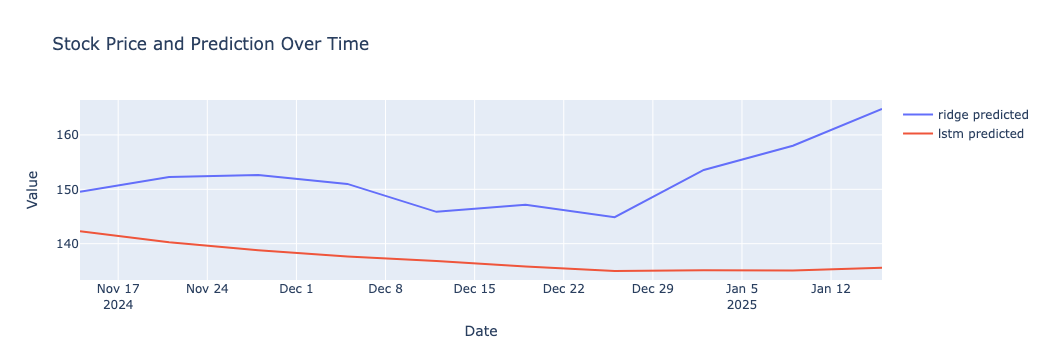

In [104]:
import plotly.express as px
import plotly.graph_objects as go


trace1 = go.Scatter(x=future_dates, y=scaler.inverse_transform(np.reshape(y_val_ridge,(-1,1))).reshape(-1), mode='lines', name='ridge predicted')
trace2 = go.Scatter(x=future_dates, y=y_val_lstm.reshape(future_days), mode='lines', name='lstm predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()

In [107]:
result_df[['earnings','observed','ridge_predicted','lstm_predicted','xgb_predicted']].tail(20)

earnings  observed  ridge_predicted  lstm_predicted  xgb_predicted
485   25.1656  191.7036       156.798855      133.416290     114.501884
486   25.1656  186.5305       170.779208      135.608017     111.454697
487   25.1656  179.1504       171.499132      137.513016     114.389648
488   25.1656  168.4547       169.894689      139.345154     114.402763
489   25.1656  168.1751       175.995234      141.615616     113.398178
490   25.1656  165.1691       179.658683      143.635376     114.217926
491   25.1656  164.5200       180.194844      145.249588     111.481079
492   25.1656  167.2064       181.600061      146.810837     111.896866
493   25.1656  164.8895       184.585554      148.340775     112.815277
494   25.1656  151.9268       186.178319      149.790344     115.416908
495   25.1656  158.3700       188.091731      151.212280     111.266518
496   25.1656  164.6400       200.468867      153.131134     105.446136
497   25.1656  165.2900       194.648573      154.437271     106.308273
498    2.7174  168.5600       185.979495      153.169495     111.567039
499    2.7174  164.5200       174.258531      152.341003     113.593109
500    2.7174  165.0500       175.204434      151.137665     111.796913
501    2.7174  166.9900       173.567499      149.591782     109.700340
502    2.7174  172.6500       168.078317      147.929871     109.279266
503    2.7174  179.8600       170.488361      146.466690     110.562141
504    2.7174  177.3500       161.956863      144.857544     109.917519